<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P0C1S1/sequences/P0C1_Introduction/P0C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **0.1.1: Evolution and Learning as Nested Optimization Processes**
A central theme in our book is that learning processes and structures in the brain are targets of evolution. This is a short sequence of interactive exercises and simulations showing how this can work. We use simple, concrete examples to anchor and illustrate this core concept.
### Objective: See how learning and evolution can act as optimization processes, shaping an organism's behaviour to better fit an ecological niche.

In this sequence we will:

* Introduce a basic eat-don't-eat binary discrimination task, which defines the ecological niche of a very simple organism.

* Implement an agent based simulation of a process of natural selection acting on inherited variation. In this first simulation, evolution selects the behavioural policy of the organism (a.k.a. its stimuli-behaviour response function) directly. This shows how a propose-accept-reject type of optimization algorithm, roughly what evolution by natural selection does, can discover a good solution behavioural policy over many generations. In this simulation the behavioural policy is specified by inherited parameters, so individuals with the same 'genotype' will express the same behaviours regardless of their past experiences.

* See how this evolutionary process responds to shifts in environment, i.e. what happens when the right kind of thing to eat changes? How long does it take for the population to adapt to the change in ecological niche?

* Extend the evolutionary simulation so that now organisms also use reward based learning to improve their behavioural policy within their lifetime. Compare the performance of this 'learning' organism with the fixed behaviour function organism for different rates of environmental change. See how this helps with resiliance. Change is the only constant

* Further extend the evolutionary model so that the learning rule itself is also a target of evolution (just learning rate or other parameters?). Again compare how quickly the population adapts to changes in ecological niche.

* Extend the model yet further allowing the structure of the behaviour generating function to also be a target of evolution. Yet again compare how quickly the population adapts to changes in ecological niche.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @markdown **Dependencies, Imports and Setup:** You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import pygraphviz as pgv
import ipywidgets as widgets
import time
import os
import gc
import copy
import tensorflow_datasets as tfds
from io import BytesIO
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from tqdm.notebook import tqdm
from typing import Tuple, Dict
import jax
import jax.numpy as jnp
import jax.random as jrandom
import jax.scipy as jscipy
from jax import grad, jit, vmap, lax

class DotDict(dict):
  def __getattr__(self, item):
    try:
      return self[item]
    except KeyError:
      raise AttributeError(f"'DotDict' object has no attribute '{item}'")

  def __setattr__(self, key, value):
    self[key] = value

  def __delattr__(self, item):
    try:
      del self[item]
    except KeyError:
      raise AttributeError(f"'DotDict' object has no attribute '{item}'")

# Load the MNIST dataset as numpy arrays
ds, ds_info = tfds.load('mnist', split='train', batch_size=-1, as_supervised=True, with_info=True)
images, labels = tfds.as_numpy(ds)  # Convert to numpy arrays
images = images.astype(np.float32) / 255.0
# grab the 1's and 0's and augment
X = np.squeeze(images)
y = labels
bin_idx = (y==0) | (y==1)
y_bin = y[bin_idx]
X_bin = X[bin_idx]

def augment_image(image):
  # Rotate the image for 0, 90, 180, and 270 degrees
  rotations = [np.rot90(image, k=i) for i in range(4)]
  # Apply horizontal flip to each rotated image
  flips = [np.fliplr(rot) for rot in rotations]
  # Return all augmented images
  return rotations + flips
# Apply augmentation
augmented_images = [augment_image(img) for img in X_bin]
# Flatten the list of lists
augmented_images = [img for sublist in augmented_images for img in sublist]
# Convert to flattened
X_bin_aug = np.array(augmented_images).reshape(-1, 28*28)
# Augment labels accordingly
y_bin_aug = np.repeat(y_bin, 8)  # Each image now has 8 versions
ones_column = np.ones((X_bin_aug.shape[0], 1))  # Create a column of ones, with the same number of rows as X_bin_aug
X_bin_aug1 = np.hstack((X_bin_aug, ones_column))  # Concatenate the column of ones to X_bin_aug horizontally

# supress some matplotlib warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

# set up plotting style
import logging
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()

# set up feedback widget
def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P0C1_S1"

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Running in colab


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.UTJGW7_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.UTJGW7_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


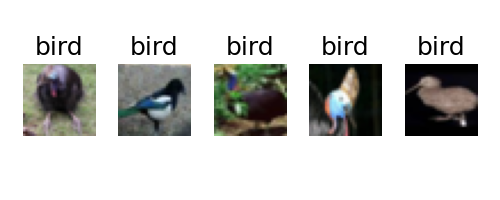

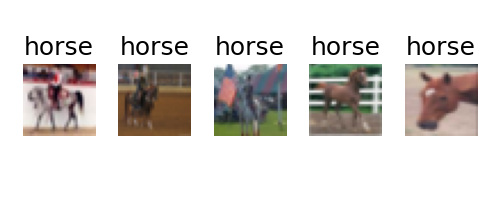

In [2]:
# Load CIFAR-10 dataset
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    batch_size=-1,
    as_supervised=True,
    with_info=True
)

# Convert to Numpy Arrays
train_images, train_labels = tfds.as_numpy(ds_train)
test_images, test_labels = tfds.as_numpy(ds_test)

# Combine training and test sets
images = np.concatenate((train_images, test_images), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)
images = images.astype(np.float32) / 255.0

# Dictionary mapping class indices to class names for CIFAR-10
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

# Function to display a few images of a given label
def display_images_of_label(images, labels, label_to_display, num_images=5):
  label_indices = [index for index, label in enumerate(labels) if label == label_to_display]
  fig, ax = plt.subplots(1, num_images, figsize=(5, 2))
  for i, index in enumerate(label_indices[:num_images]):
    ax[i].imshow(images[index])
    ax[i].set_title(cifar10_labels[label_to_display])
    ax[i].axis('off')
    remove_ip_clutter(fig)
  plt.show()

# Example: Display a few images of label "bird" (label index 2)
display_images_of_label(images, labels, label_to_display=2)
# Example: Display a few images of label "horse" (label index 7)
display_images_of_label(images, labels, label_to_display=7)

In [3]:
# Extract birds (label 2) and frogs (label 6)
bird_frog_mask = np.isin(labels, [2, 6])
bird_frog_images = images[bird_frog_mask]
bird_frog_labels = labels[bird_frog_mask]

# Map the labels to 0 and 1 for binary classification (bird=0, frog=1)
bird_frog_labels = np.where(bird_frog_labels == 2, 0, 1)

# Flatten for fully connected layers
flat_bird_frog_images = bird_frog_images.reshape(bird_frog_images.shape[0], -1)

# Add a constant feature to the flattened images
constant_feature = np.ones((flat_bird_frog_images.shape[0], 1))
flat_bird_frog_images_aug1 = np.hstack((flat_bird_frog_images, constant_feature))

# Display the shapes of the resulting dataset
print("Shape of bird and frog images:", bird_frog_images.shape)
print("Shape of bird and frog labels:", bird_frog_labels.shape)
print("Shape of flat bird and frog images:", flat_bird_frog_images.shape)
print("Shape of flat bird and frog images with constant feature:", flat_bird_frog_images_aug1.shape)

Shape of bird and frog images: (12000, 32, 32, 3)
Shape of bird and frog labels: (12000,)
Shape of flat bird and frog images: (12000, 3072)
Shape of flat bird and frog images with constant feature: (12000, 3073)


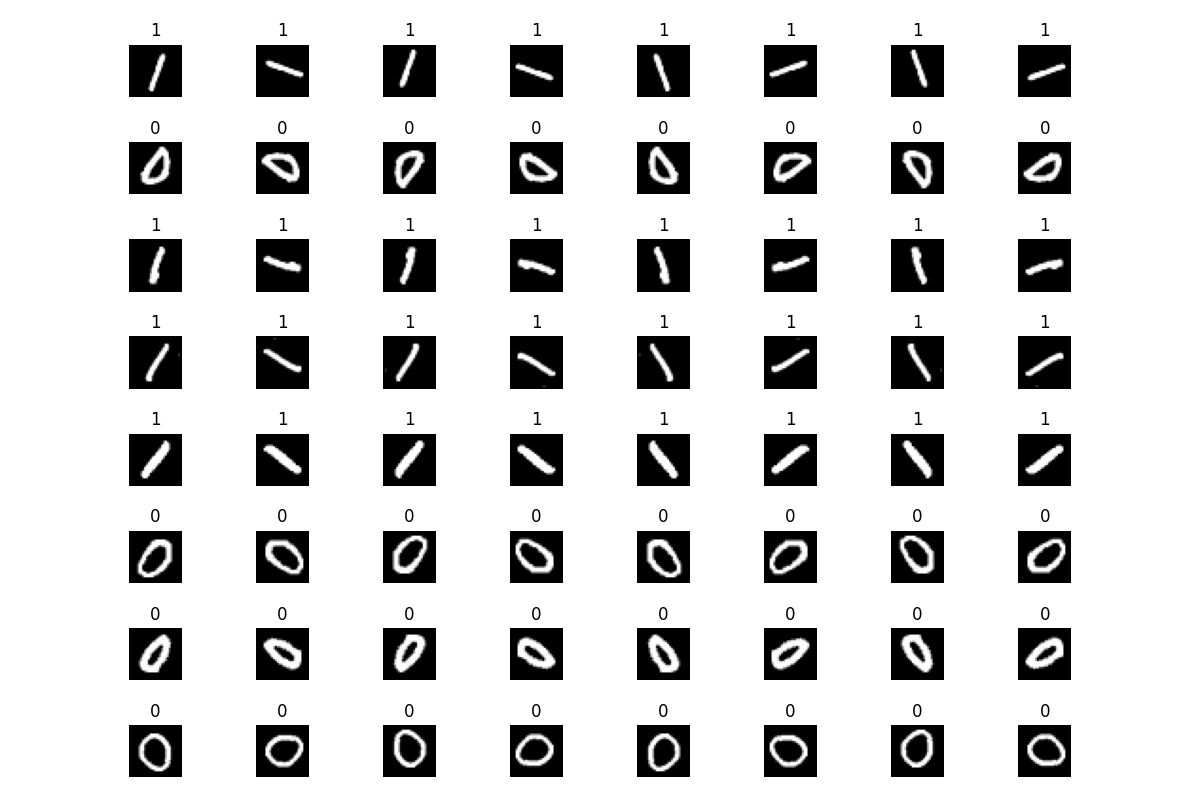

In [4]:
num_images = 64
rows = 8
cols = int(num_images / rows)
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))  # Set up a row of 10 subplots
for r_ in range(rows):
  for c_ in range(cols):
    ax = axes[r_, c_]
    ax.imshow(X_bin_aug1[r_*cols + c_][:784].reshape(28, 28), cmap='gray')  # Ensure using the right colormap if needed
    ax.axis('off')  # Hide axes for clarity
    ax.set_title(str(y_bin_aug[r_*cols + c_]), fontsize=12)  # Use set_title to display the label below each image
plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

# 0.1.1.1: To Eat Or Not To Eat, That is The Question



## Life History Picture

In this sequence we consider the life and evolution of a population of cartoonishly simple organisms. The life cycle of this organism is dominated almost entirely by the simple binay decision problem illustrated and described below.

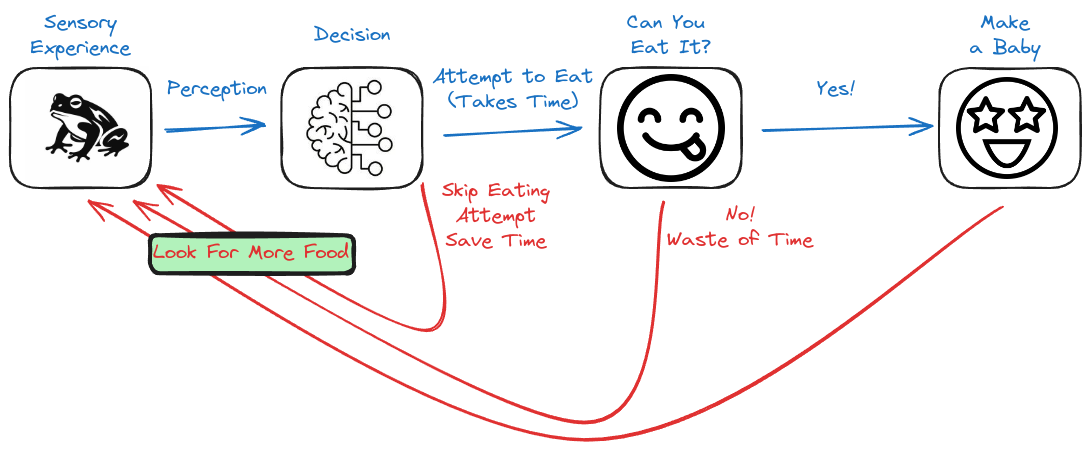

In this simulation an organism's life consist of a series of episodes. Each episode is initiated by the seneory experience of something that the organism might eat. Based on this sensory experience the organism has to make a decision: approach and eat the food, which will take some time and effort; or skip eating and save some time and effort. If the organism skips eating, then the episode ends after the organism has spent only one time unit (percieving and deciding takes one time unit) of their precisous life on this episode. Alternatively if they choose to approach and eat, they spend an additional time unit of life, and get have another sensory experience, this time the taste of the thing that they tried to eat. If the food was nutritous, they become more fat and happy and are thus more likely to have spawn offspring that survive into the next generation of the population. If though, the food is not nutritious, they have now wasted a total of two time units of their short sweet precious time alive (one unit percieving and deciding to approach, one unit approaching and tasting) and they are no more likely to have progeny for their effort.

That describes the core activity of the organisms in their niche, now let's describe the rest of their life history. Each generation, every organism lives for exactly 200 time units, at which point they die. The ecological niche where this population lives can support a maximum of 100 individuals. All of the babies born in the previour generation compete to become one of the 100 adults in the next generation. Children mostly resemble their parents. Specifically, how organisms approach the binary discrimination problem described above will depend on a number of real valued parameters (exactly how to be discussed shortly). Children will have the same parameter values as their parents, perturbed by Gaussian noise. Note there is no model here of the specific process of genetic inheritence and development, Gaussian noise on parameters is a rough substitute for explicitly modeled mechanisms of inheritence and development, serving as a kind of rug thrown over the complexity of the interactions between genes, how they change through point-mutations and recombination, and how these changes affect behavioural phenotype through a developmental process.



___
## Pedagogy Note: Simple Problems

Throughout this book we will typically ground our discussion in the simplest possible 'toy problems'. Problems are selected for there didactic value, not their realism, because they definatively prove something, or because they make a good prediction or description of some empirical phenomena. However, in the final chapters of the book as a kind of proof of principles we show how the core concepts introduced throughout the book can be complexified along two axis of biological plausibility, 1) alignment with known electro-physiology, 2) ability to solve the challenging learning problems like those encountered by real organisms. These more complex models are less useful for understanding principles, which is why they come at the end, but potentially much more useful in describing and predicting data in an empirical settings.
___

## Interaction: Trying Out Eat Don't Eat

In [5]:
# @markdown **Run this cell** to try out the 'eat-don't-eat' discrimination task faced by the organisms in our simulation.

class InteractiveMNISTPredator():
  def __init__(self,
               features=X_bin_aug1,
               labels=y_bin_aug,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    self.time_spent = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description="Eat")
    self.no_strike_button = widgets.Button(description="Don't Eat")
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(1, 1))
    remove_ip_clutter(self.fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.feedback_display,
                                                         self.score_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    #if len(image) == 785:
    #    image = image[:784].reshape(28,28)
    #else:
    #  raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image)
    self.fig.canvas.draw_idle()  # Force redraw

  def on_strike_clicked(self, button):
    self.process_decision("Eat")

  def on_no_strike_clicked(self, button):
    self.process_decision("Don't Eat")

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    should_eat = self.labels[self.current_index] == 1
    correct_string = "You manged to eat it and it was nutritious, you make a baby!" if should_eat else 'The food flew away, what a waste of time, no baby today.'
    if decision == "Eat":
      self.time_spent += 2
      if should_eat:
        self.successful_strikes += 1
      else:
        self.failed_strikes += 1
    elif decision == "Don't Eat":
      self.time_spent += 1
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == "Eat")):
      # Show informative feedback
      feedback = f'You spent some time trying to eat that.\n{correct_string}'
    else:
      # Show uninformative feedback
      feedback = "You didn't try to eat that.\nMoving on to the next thing, no time wasted."
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Time Spent Searching: {self.current_index + 1}')
      print(f'Time Spent Eating: {self.failed_strikes + self.successful_strikes}')
      print(f'Total Time Spent: {self.time_spent}')
      print(f'Babies Made: {self.successful_strikes}')
      print(f'Babies Made per Time Spent: {(self.successful_strikes/self.time_spent):.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


bin_imp = InteractiveMNISTPredator(features=bird_frog_images,
                                            labels=bird_frog_labels, feedback_type='on_strike_only')
display(bin_imp.fig.canvas)
clear_output()
display(bin_imp.ui)

Were you able to detect a pattern? You may have noticed that frog are good to try to eat whereas birds are a waste of time (they fly away before you can eat them I guess). Now that we have a sense of what the core decision problem for the organism is, let's take a look at how the decision function works.

## Decision as Computation

In more detail the task these organisms face is to take the inputs from their 32x32 pixels x 3 colour channels receptive field, and based on this decide whether to approach the food and try to eat it, or skip approaching that potential food and start searching for the next thing to eat. Approaching and attempting to eat food takes time, so trying to eat things that are not nutritious wastes time, ultimately leading to reduced reproduction. If we want to simulate an evolutionary process centered around this decision problem we first need to specify the nature of the behavioural policy, denoted $\pi$ (for policy).

We model this organism's behavioural policy as follows. We let $\mathbf{x}$ be the raw (visual) sensory input (column vector) of length 3072 in a given episode. (This can be reshaped into the $32\times32\times3$ receptive field we saw in the example.) We can think of each element $x_i$ of $\mathbf{x}$ as corresponding to the activation level of a single photosensitive receptor.

These input neurons are then connected to two output neurons, each one corresponding one of the two possible action selections, "eat" or "don't eat".

The activation level, as a vector $\mathbf{z}$, of these output neurons is computed as
$$ \mathbf{h} = \sigma(\mathbf{W}^1\mathbf{x}) $$
$$\mathbf{z} = \mathbf{W}^{\text{s}}\mathbf{x} + \mathbf{W}^2 \mathbf{h}$$
Here $\mathbf{h}$ is the activity of an intermediate (or hidden) layer of neurons, $\sigma$ is the standard logistic sigmoid function applied elementwise. This non-linearity allows for greater computationally flexibility in the behaviour function. $\mathbf{W}^1$, $\mathbf{W}^{\text{s}}$, and $\mathbf{W}^2$ are matrices of synaptic weights between the input neurons and the intermediate nuerons, the input neurons and the output neurons, and the intermediate neurons and the output neurons respectively. In this case where there are 3073 inputs (we have done a standard 'trick' of augmenting $\mathbf{x}$ with a feature of contant value, hence 3073 inputs instead of 3072 which allows for a parameterizable baseline level of activation independent of sensory input) and 3 intermediate neurons, and 2 outputs, so $\mathbf{W}^1$ has shape $20 \times 3073$, $\mathbf{W}^\text{s}$ has shape $2 \times 3073$ and $\mathbf{W}^3$ has shape $2 \times 20$. This gives us
$$ h_i = \sigma \left( \sum_{j=1}^{3073} w^1_{ij} x_j \right)$$
and
$$ z_i = \sum_{j=1}^{3073} w^\text{s}_{ij} x_j + \sum_{j=1}^{20} w^2_{ij} h_j$$

**Notation Note**: $w_{ij}$ is the weight connecting the $j^{th}$ input to the $i^{th}$ output and is the element in the $i^{th}$ row and $j^{th}$ column of $\mathbf{W}$. Superscripts on $\mathbf{W}$ and $w$ indicate the specific layer of connections, $1^{st}$, $2^{nd}$ or skip.

**Sigmoid Definition**: $$\sigma(x) := \frac{\exp(x)}{1+\exp(x)}$$

To convert these activation levels, $\mathbf{z}$, into probabilities of taking actions we use softmax normalization. Softmax can be thought of as an extension of the logistic sigmoid function to multiple classes. (Even though we only have two classes here and we could use a logistic sigmoid function, mathematically and conceptually things work out more cleanly when we use the softmax function). Much like the logistic sigmoid turns any real number into a probability over a binary outcome (approach, avoid), the softmax function turns any vector of real values into a vector of probabilities over different outcomes
$$\text{softmax}(\mathbf{z}) := \frac{(\exp{z_0}, \dots, \exp(z_i), \dots, \exp(z_n))}{\sum_k \exp(z_k)}$$

We use a subscript to refer to a particular element of the softmax output so that probability of choosing a particular action $i$ can be expressed as:
$$ \Pr \{\text{action }i\} = \text{softmax}_i(\mathbf{z}) = \frac{\exp(z_i)}{\sum_k \exp(z_k)} $$

When there are only two possible actions, and one action has a fixed activation of $0$, then softmax normalization is equivalent to applying the logistic sigmoid of the variable (non-zero) activation level, to determine action probabilities.

Given all this, the behavioural policy $\pi$ is a function that gives the probability of taking the different possible actions, for a given sensory input. So in this particular case
$$\pi(\text{Approach} |\mathbf{x}) = \text{softmax}_0(\mathbf{W}^s\mathbf{x} + \mathbf{W^2}\sigma(\mathbf{W}^1\mathbf{x}))$$
and
$$\pi(\text{Avoid} |\mathbf{x}) = \text{softmax}_1(\mathbf{W}^s\mathbf{x} + \mathbf{W^2}\sigma(\mathbf{W}^1\mathbf{x}))$$

A rough schematic of this computation is shown below

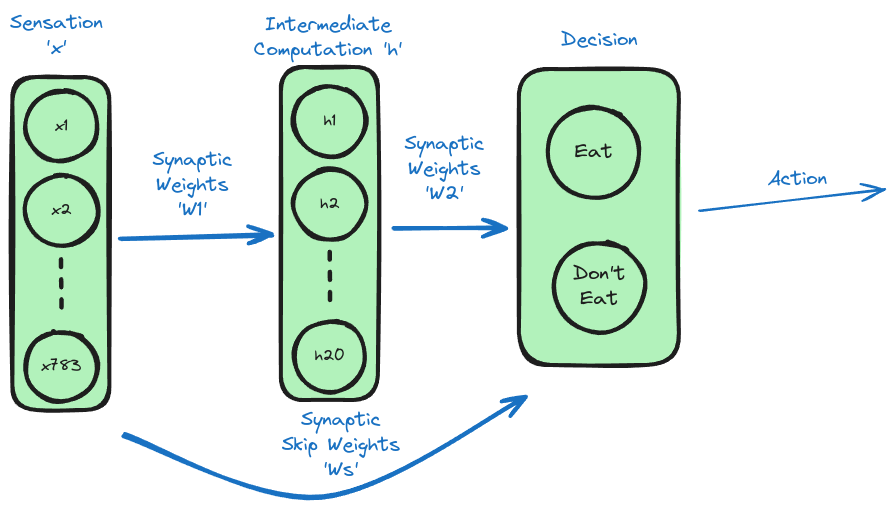

## Coding Exercise: Implement a Decision Function

That's the math of the decision problem. Now, how do we get a computer to actually implement that decision function? Do the coding exercise below to find out.

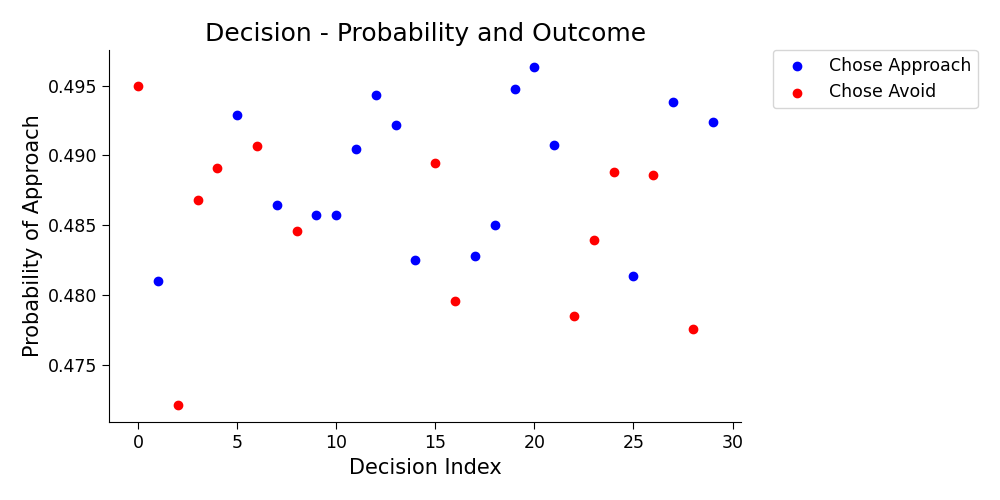

In [6]:
# to_remove solution

def jnp_sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

def jnp_softmax(x):
  e_x = jnp.exp(x - jscipy.special.logsumexp(x))
  return e_x

def calc_decision_probs(x: jnp.ndarray,   # n_in
                        W1: jnp.ndarray,  # n_hid x n_in
                        Ws: jnp.ndarray,  # n_out x n_in
                        W2: jnp.ndarray) -> jnp.ndarray: # n_out x n_hid
  h = jnp_sigmoid(W1 @ x) # n_hid
  z = (Ws @ x) + (W2 @ h) # n_out
  probs = jnp_softmax(z) # n_out
  return probs

batch_calc_decision_probs = vmap(calc_decision_probs,
                                 in_axes=(0, None, None, None))

def make_decision(x: jnp.ndarray,   # n_in
                  W1: jnp.ndarray,  # n_hid x n_in
                  Ws: jnp.ndarray,  # n_out x n_in
                  W2: jnp.ndarray,  # n_out x n_hid
                  rnd_key: jrandom.key) -> int:
  h = jnp_sigmoid(W1 @ x) # n_hid
  z = (Ws @ x) + (W2 @ h) # n_out
  action = jrandom.categorical(rnd_key, logits=z) # scalar
  return action

# sensory inputs and rnd_keys need to come in batches
batch_make_decision = vmap(make_decision, in_axes=(0, None, None, None, 0))

# plotting outcome of randomly initialized policy
# Define the dimensions
#n_in = 28 * 28 + 1  # 28 x 28 pixel features + 1 bias
#n_in = 96 * 96 * 3 + 1 # 96 x 96 pixesl x 3 color channels + 1 bias
n_in = 32 * 32 * 3 + 1 # 32 x 32 pixels x 3 color channels + 1 bias
n_hid = 20
n_out = 2
# Initialize weights
rnd_key = jrandom.key(0)
rnd_key, rs1, rs2, rs3 = jrandom.split(rnd_key, num=4)
W1_test = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10 # Weights from input to hidden layer
Ws_test = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10 # Weights from input to output
W2_test = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10 # Weights from hidden to output
# Grab test data
#x_batch = jnp.array(X_bin_aug1[:30,:])
x_batch = jnp.array(flat_bird_frog_images_aug1[:30])
# make decision
probabilities = batch_calc_decision_probs(x_batch, W1_test, Ws_test, W2_test)
rnd_key, *batch_dec_keys = jrandom.split(rnd_key, 31)
batch_dec_keys = jnp.array(batch_dec_keys)
samples = batch_make_decision(x_batch, W1_test, Ws_test, W2_test, batch_dec_keys)

# Plot results batch
fig, ax = plt.subplots(figsize=(10, 5))
eating_indices = [i for i, s in enumerate(samples) if s == 0]
not_eating_indices = [i for i, s in enumerate(samples) if s == 1]
eating_probabilities = [probabilities[i, 0] for i in eating_indices]
not_eating_probabilities = [probabilities[i, 0] for i in not_eating_indices]
ax.scatter(eating_indices, eating_probabilities, color='blue', label='Chose Approach')
ax.scatter(not_eating_indices, not_eating_probabilities, color='red', label='Chose Avoid')
ax.set_title('Decision - Probability and Outcome')
ax.set_xlabel('Decision Index')
ax.set_ylabel('Probability of Approach')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
remove_ip_clutter(fig)
plt.show()

The important thing to note here is the fundamental stochasticity in the decision function. This particular initialization seems to be slight biased towards `avoid`, but even so `approach` actions are still taken with some frequency. Different parameterizations of the behavioural policy can have more or less variability in action selection given a particular sensory experience.

# 0.1.1.2 Evolving a Good Behavioural Policy with Selection on Noisy Heritable Variation:

Now we get to see the power of selection in action. A very simple process, generates variation and then selects from amongst that variation for those variants that perform better according to some criterion (in this case eat more nutritious things in a life). This process is applied iteratively over many generations, using the selected variants as the starting point for the next generation's variation. By iterating this simple process we can arrive at an effective solution to this eat-don't-eat binary discrimination problem. Let's code it up and see it in action.

## Coding Exercsise: Implement Behaviour Policy Evaluation

We have our decision function already, but now we need a way of evaluating this decision function, i.e. giving it a score upon which will determine how many offspring an organism will contribute to the next generation. This score should be how many times an organism approaches nutritious food in it's life. Complete the coding exercise below to calculate the score for an organism with a given decision function, assuming a given sequence of episodes.

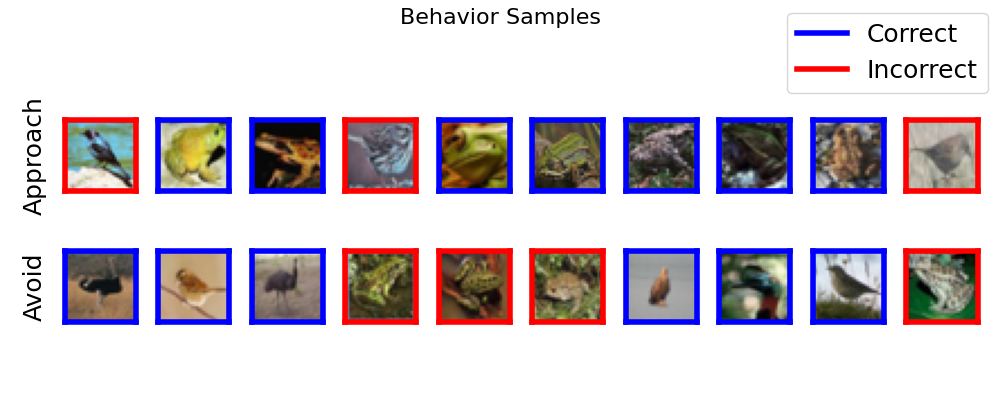

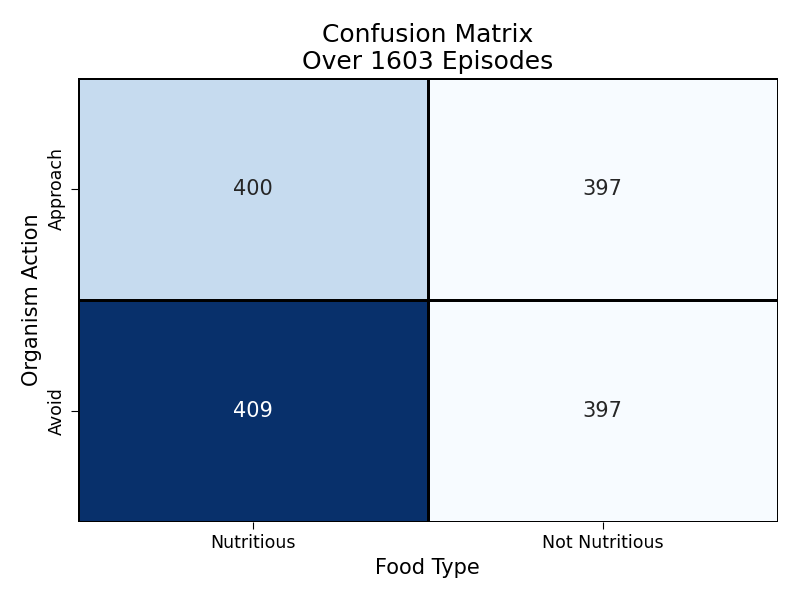

In [7]:
# to_remove solution

def eval_policy(W1: jnp.ndarray,  # shape: (n_hid, n_in)
                Ws: jnp.ndarray,  # shape: (n_out, n_in)
                W2: jnp.ndarray,  # shape: (n_out, n_hid)
                X: jnp.ndarray,   # shape: (batch_size, n_in)
                y: jnp.ndarray,   # shape: (batch_size,)
                rnd_key: jrandom.key,
                nutritious_type: int,
                lifetime: int) -> Tuple[int, int, int, int]:   # TP, FN, FP, TN
  """
  Evaluate policy function.
  Args:
    W1 (jnp.ndarray): First layer weights, shape (n_hid, n_in).
    Ws (jnp.ndarray): Second layer weights, shape (n_out, n_in).
    W2 (jnp.ndarray): Third layer weights, shape (n_out, n_hid).
    rnd_key (jrandom.key): JAX random key.
    X (jnp.ndarray): Input data, shape (batch_size, n_in).
    y (jnp.ndarray): Target labels, shape (batch_size,).
    nutritious_type (int): Integer label indicating the type.
    lifetime (int): Positive integer, should be batch size.
  Returns:
    Tuple[int, int, int, int]: Counts of true positives, false negatives, false positives, and true negatives.
  """
  batch_size = y.shape[0]
  batch_dec_keys = jrandom.split(rnd_key, batch_size)
  batch_dec_keys = jnp.array(batch_dec_keys)
  actions = batch_make_decision(X, W1, Ws, W2, batch_dec_keys) # batch x n_out
  did_approach = actions == 0
  did_avoid = actions == 1
  was_nutritious = y == nutritious_type # batch
  was_waste = y != nutritious_type
  batch_time = jnp.where(did_avoid, 1, 2)  # 1 time unit for avoid, 2 for approach
  batch_TP = jnp.where(was_nutritious & did_approach, 1, 0)
  batch_FP = jnp.where(was_waste & did_approach, 1, 0)
  batch_FN = jnp.where(was_nutritious & did_avoid, 1, 0)
  batch_TN = jnp.where(was_waste & did_avoid, 1, 0)
  # only count what happens before they run out of time
  cum_time = jnp.cumsum(batch_time)
  indices = cum_time <= lifetime
  batch_TP = jnp.where(indices, batch_TP, 0)
  batch_FP = jnp.where(indices, batch_FP, 0)
  batch_FN = jnp.where(indices, batch_FN, 0)
  batch_TN = jnp.where(indices, batch_TN, 0)
  TP = jnp.sum(batch_TP)
  FP = jnp.sum(batch_FP)
  FN = jnp.sum(batch_FN)
  TN = jnp.sum(batch_TN)
  return TP, FN, FP, TN, actions, was_nutritious

# plotting outcome of randomly initialized net
# Initialize parameters of the simulation
# n_in = 28 * 28 + 1 # 28 x 28 pixels + 1 bias
#n_in = 96 * 96 * 3 + 1 # 96 x 96 pixels x 3 color channels + 1 bias
n_in = 32 * 32 * 3 + 1 # 32 x 32 pixels x 3 color channels + 1 bias
n_hid = 20
n_out = 2
lifetime = 2400
test_size = lifetime
nutritious_type = 1
# Initialize behavioural policy parameters, all zeros to start
W1_test = jnp.zeros((n_hid, n_in)) # Weights from input to hidden layer
Ws_test = jnp.zeros((n_out, n_in)) # Weights from input to output
W2_test = jnp.zeros((n_out, n_hid)) # Weights from hidden to output
# Get test data
#X = jnp.array(X_bin_aug1)
#y = jnp.array(y_bin_aug)
#X = jnp.array(flat_bird_monkey_images_aug1)
#y = jnp.array(bird_monkey_labels)
X = jnp.array(flat_bird_frog_images_aug1)
y = jnp.array(bird_frog_labels)

shape_dummy = jnp.zeros(int(lifetime))

@jit
def grab_batch_data(X, y, rnd_key, size_dummy):
  indices = jrandom.choice(rnd_key, X.shape[0], size_dummy.shape, replace=False)
  X_batch = X[indices]
  y_batch = y[indices]
  return X_batch, y_batch

rnd_key = jrandom.key(0)
rnd_key, sel_key = jrandom.split(rnd_key)
X_test, y_test = grab_batch_data(X, y, sel_key, shape_dummy)

# Evaluate
rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN, actions, was_nutritious = eval_policy(
  W1_test, Ws_test, W2_test, X_test, y_test, eval_key,
  nutritious_type=nutritious_type, lifetime=lifetime)

def plot_behavior_samples(X, y, actions, was_nutritious, num_samples=10, title='Behavior Samples'):
  """
  Plot images of samples with border colors indicating correct (blue) and incorrect (red) decisions.
  Args:
      X (jnp.ndarray): Input data, shape (batch_size, n_in).
      y (jnp.ndarray): Target labels, shape (batch_size,).
      actions (jnp.ndarray): Decision actions, shape (batch_size,).
      was_nutritious (jnp.ndarray): Whether each sample was nutritious, shape (batch_size,).
      title (str): Title of the plot.
  """
  # Colors for correct and incorrect decisions
  correct_color = "blue"
  incorrect_color = "red"
  approach_indices = jnp.where(actions == 0)[0][:num_samples]  # Select first 10 approach
  avoid_indices = jnp.where(actions == 1)[0][:num_samples]     # Select first 10 avoid
  # Adjust the number of columns to the actual number of samples
  num_approach_samples = len(approach_indices)
  num_avoid_samples = len(avoid_indices)
  max_samples = max(num_approach_samples, num_avoid_samples)
  fig, axes = plt.subplots(2, max_samples, figsize=(10, 4))  # 2 rows, max_samples columns
  fig.suptitle(title, fontsize=16)

  for i in range(num_samples):
    if i < num_approach_samples:
      idx = approach_indices[i]
      image = X[idx][:(32 * 32 * 3)].reshape(32, 32, 3)
      if was_nutritious[idx]:
        border_color = correct_color
      else:
        border_color = incorrect_color
      axes[0, i].imshow(image)
      for spine in axes[0, i].spines.values():
          spine.set_edgecolor(border_color)
          spine.set_linewidth(4)
    else:
      axes[0, i].imshow(np.ones((32, 32, 3)))  # Display blank space
      for spine in axes[0, i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(4)
    axes[0, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axes[0, i].spines['top'].set_visible(True)
    axes[0, i].spines['right'].set_visible(True)

    if i < num_avoid_samples:
      idx = avoid_indices[i]
      image = X[idx][:(32 * 32 * 3)].reshape(32, 32, 3)
      if not was_nutritious[idx]:
        border_color = correct_color
      else:
        border_color = incorrect_color
      axes[1, i].imshow(image)
      for spine in axes[1, i].spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(4)
    else:
      axes[1, i].imshow(np.ones((32, 32, 3)))  # Display blank space
      for spine in axes[1, i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(4)
    axes[1, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axes[1, i].spines['top'].set_visible(True)
    axes[1, i].spines['right'].set_visible(True)

  # Add labels to the rows
  axes[0, 0].annotate('Approach', xy=(0, 0.5), xytext=(-axes[0, 0].yaxis.labelpad - 5, 0),
                      xycoords=axes[0, 0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', rotation=90)
  axes[1, 0].annotate('Avoid', xy=(0, 0.5), xytext=(-axes[1, 0].yaxis.labelpad - 5, 0),
                      xycoords=axes[1, 0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center', rotation=90)
  # Create custom legend
  legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Correct'),
                     Line2D([0], [0], color='red', lw=4, label='Incorrect')]
  fig.legend(handles=legend_elements, loc='upper right', fontsize='large')
  remove_ip_clutter(fig)
  plt.show()

plot_behavior_samples(X_test, y_test, samples, was_nutritious, num_samples=10)

def plot_confusion(TP, FN, FP, TN, title='Confusion Matrix'):
  """
  Plot confusion matrix with blue borders for correct decisions and red borders for incorrect decisions.
  Args:
    TP (int): True Positives count.
    FN (int): False Negatives count.
    FP (int): False Positives count.
    TN (int): True Negatives count.
    title (str): Title of the plot.
  """
  total_trials = TP + FN + FP + TN
  confusion_matrix = np.array([[TP, FP], [FN, TN]])
  fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
  sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g', cbar=False, linewidths=2, linecolor='black')
  # Labels, title and ticks
  column_labels = ['Nutritious', 'Not Nutritious']
  row_labels = ['Approach', 'Avoid']
  ax.set_xlabel('Food Type')
  ax.set_ylabel('Organism Action')
  ax.set_title(title + f'\nOver {total_trials} Episodes')
  ax.xaxis.set_ticklabels(column_labels)
  ax.yaxis.set_ticklabels(row_labels)
  remove_ip_clutter(fig)
  plt.show()

plot_confusion(TP, FN, FP, TN)

Looking at the confusion matrix (what the organism did in different cases, contrasted with what it should have done) we see that over ### trials it approached and ate nutritious food ## times, so this would be the score that determines how likely this organism is to be a parent in the next generation. It spent its 3000 unit lifetime on those ### trials as follows:
In ### of them it avoided food, and this used 116 time units of life. Of these ### times it chose avoid, in ## of them it made the 'wrong' choice and missed out on nutritious food, but in ## of them in made the 'right' choice and avoided wasting time on non-nutritious food. In ## cases it approached food, taking up 184 time units of life. Of these ## approach cases, ## times it approached nutritious food, but ## times it approached non-nutritrious food that it would have been better off avoiding. In this test case the organism is initilized with zeroed out parameter weights so it is equally likely to approach or avoid independent of what it senses. If instead, the organism had parameters that allowed it to perfectly discriminate between nutritiours and non-nutritious food it would have been able to get a score of at least ## instead of ##, possibly more depending on the order of experiences.

## Coding Exercise: Implement Agent Based Evolution Simulation

Now that we have an evaluation function for these organisms, something that measures how well fit to their (very simple) ecological niche we are in a possition to implement a simulation of their life history and the evolutionary process.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


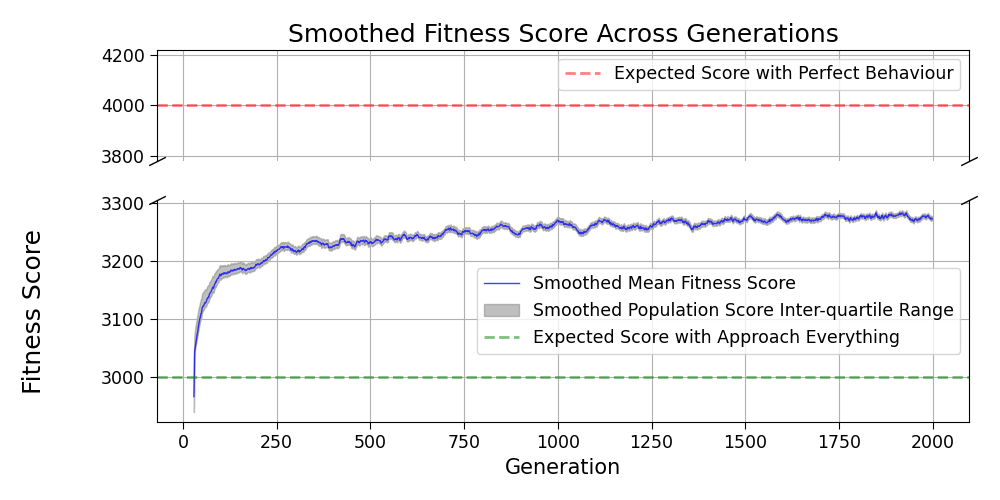

In [9]:
# Define paths to load arrays
generations_path = '/content/drive/My Drive/evo_sim_10_pager/generations.npy'
mean_fitness_path = '/content/drive/My Drive/evo_sim_10_pager/mean_fitness.npy'
q25_fitness_path = '/content/drive/My Drive/evo_sim_10_pager/q25_fitness.npy'
q75_fitness_path = '/content/drive/My Drive/evo_sim_10_pager/q75_fitness.npy'

lifetime = 12000

# Load arrays from Google Drive
generations = np.load(generations_path)
mean_fitness = np.load(mean_fitness_path)
q25_fitness = np.load(q25_fitness_path)
q75_fitness = np.load(q75_fitness_path)

generations_series = pd.Series(generations)
mean_fitness_series = pd.Series(mean_fitness)
q25_fitness_series = pd.Series(q25_fitness)
q75_fitness_series = pd.Series(q75_fitness)

# Define the window size for rolling average
window_size = 30

# Compute rolling averages
mean_fitness_smooth = mean_fitness_series.rolling(window=window_size).mean()
q25_fitness_smooth = q25_fitness_series.rolling(window=window_size).mean()
q75_fitness_smooth = q75_fitness_series.rolling(window=window_size).mean()

# Creating the broken axis plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.05)  # Adjust space between axes
# Plot the smoothed data on both axes
ax2.plot(generations, mean_fitness_smooth, label='Smoothed Mean Fitness Score', color='blue', linewidth=1, alpha=0.75)
ax2.fill_between(generations, q25_fitness_smooth, q75_fitness_smooth, color='gray', alpha=0.5, label='Smoothed Population Score Inter-quartile Range')
ax1.axhline(y=lifetime/3, color='red', linestyle='--', linewidth=2, label='Expected Score with Perfect Behaviour', alpha=0.5)
ax2.axhline(y=lifetime/4, color='green', linestyle='--', linewidth=2, label='Expected Score with Approach Everything', alpha=0.5)

# Hide the spines between ax1 and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax1.spines.top.set_visible(True)
ax2.spines.right.set_visible(True)
ax1.spines.right.set_visible(True)
ax1.tick_params(top=False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Add slanted lines to indicate the break
d = .5  # Proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Titles and labels
ax1.set_title('Smoothed Fitness Score Across Generations')
ax2.set_xlabel('Generation')
# Add a single y-axis label using annotate
ax2.annotate('Fitness Score', xy=(0, 0.5), xytext=(-ax2.yaxis.labelpad - 40, 0),
             xycoords=ax2.yaxis.label, textcoords='offset points',
             size='large', ha='center', va='center', rotation=90)

# Grid and legend
ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()

remove_ip_clutter(fig)
plt.show()

In [ ]:
# to_remove solution
def init_pop_params(pop_size: int, n_in: int, n_hid: int, n_out: int, rnd_key: jrandom.key) -> Dict[str, jnp.ndarray]:
  rnd_key, sub_key = jrandom.split(rnd_key)
  W1 = jrandom.normal(sub_key, (pop_size, n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10
  rnd_key, sub_key = jrandom.split(rnd_key)
  Ws = jrandom.normal(sub_key, (pop_size, n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10
  rnd_key, sub_key = jrandom.split(rnd_key)
  W2 = jrandom.normal(sub_key, (pop_size, n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10
  pop_params = {'W1': W1, 'Ws': Ws, 'W2': W2}
  return pop_params

def evaluate_population(population, X, y, lifetime, nutritious_type, rnd_key):
  def step(carry, idx):
    fitness_scores, rnd_key = carry
    critter_W1 = population['W1'][idx]
    critter_Ws = population['Ws'][idx]
    critter_W2 = population['W2'][idx]
    rnd_key, eval_key = jrandom.split(rnd_key)
    TP, _, _, _, _, _ = eval_policy(
      critter_W1, critter_Ws, critter_W2, X, y, eval_key,
      nutritious_type, lifetime)
    fitness_scores = fitness_scores.at[idx].set(TP)
    return (fitness_scores, rnd_key), None
  pop_size = population['W1'].shape[0]
  fitness_scores = jnp.zeros(pop_size)
  carry = (fitness_scores, rnd_key)
  idxs = jnp.arange(pop_size)
  carry, _ = lax.scan(step, carry, idxs)
  fitness_scores, _ = carry
  return fitness_scores

@jit
def select_parents(fitness_scores, rnd_key, sel_str):
  # note that probability of being a parent is directly proportional to
  # 'fitness' score resulting from the evaluaton function
  probabilities = jnp_softmax(fitness_scores/sel_str)
  probabilities = probabilities / probabilities.sum()  # Normalize to ensure sum is exactly 1
  cumulative_probabilities = jnp.cumsum(probabilities)
  selection_points = jrandom.uniform(rnd_key, (len(fitness_scores),))
  parent_indices = jnp.searchsorted(cumulative_probabilities, selection_points)
  return parent_indices

def add_noise(W, rnd_key, mutation_scale):
  noise = jrandom.normal(rnd_key, W.shape) * mutation_scale
  return W + noise

@jit
def mutate(pop_params: Dict[str, jnp.ndarray], rnd_key: jrandom.PRNGKey, mutation_scale: float) -> Dict[str, jnp.ndarray]:
  mutated_params = {}
  for key, param in pop_params.items():
    rnd_key, mut_key = jrandom.split(rnd_key)
    mutated_params[key] = add_noise(param, mut_key, mutation_scale)
  return mutated_params

#simulation params
num_generations = 2000 # takes forever, 2000 makes a good picture, to really it in at mut scale 0.2, sel_temp 2.0 with per individual environmental variation
print_freq = 5
lifetime = 3000
pop_size = 500
nutritious_type = 1
mut_scale = 0.2
softmax_selection_strength_temp = 2.0 # close to zero is strong selection, large positive is weak selection
#n_in = 28 * 28 + 1
#n_in = 96 * 96 * 3 + 1
n_in = 32 * 32 * 3 + 1
n_hid = 20
n_out = 2

shape_dummy = jnp.zeros(int(lifetime))

#init the population
rnd_key = jrandom.key(0)
pop_params = init_pop_params(pop_size, n_in, n_hid, n_out, rnd_key)
best_params = {}

fitness_history = []
start_time = time.time()
for g in range(num_generations):
  gen_start_time = time.time()
  #evaluate policies
  rnd_key, grab_key, eval_key, sel_key, mut_key = jrandom.split(rnd_key, 5)
  X_, y_ = grab_batch_data(X, y, grab_key, shape_dummy)
  rnd_key, eval_key = jrandom.split(rnd_key)
  fitness_scores = evaluate_population(pop_params, X_, y_, lifetime, nutritious_type, eval_key)
  del X_, y_
  # random selection using fitness_scores
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key, softmax_selection_strength_temp)
  unique_parents_count = len(jnp.unique(parent_indices))
  if g == num_generations - 1:
    best_idx = jnp.argmax(fitness_scores)  # Find the index of the highest fitness score
    best_params = {key_: pop_params[key_][best_idx] for key_ in pop_params.keys()}  # Retrieve the best individual's parameters
  # Create new population with mutation
  parent_params = {key: pop_params[key][parent_indices] for key in pop_params.keys()}
  rnd_key, mut_key = jrandom.split(rnd_key)
  pop_params = mutate(parent_params, mut_key, mut_scale)
  del parent_params
  # data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'std_dev_fitness': jnp.std(fitness_scores).item(),
    'q05_fitness': jnp.percentile(fitness_scores, 5).item(),
    'q95_fitness': jnp.percentile(fitness_scores, 95).item(),
    'unique_parents_count': unique_parents_count,
  })
  current_gen_data = fitness_history[-1]
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  if g % print_freq == 0:
    selected_fitness = fitness_scores[parent_indices]
    not_selected_indices = jnp.setdiff1d(jnp.arange(pop_size), parent_indices)
    not_selected_fitness = fitness_scores[not_selected_indices]
    mean_selected_fitness = jnp.mean(selected_fitness)
    mean_not_selected_fitness = jnp.mean(not_selected_fitness)
    print(f"Gen: {g}/{num_generations} | Avg: {current_gen_data['mean_fitness']:.4f} | Std: {current_gen_data['std_dev_fitness']:.4f} | Par Prop: {current_gen_data['unique_parents_count'] / pop_size:.4f} | Fit dif:{mean_selected_fitness - mean_not_selected_fitness:.4f} |Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")
  del fitness_scores
  del parent_indices
  del grab_key, eval_key, sel_key, mut_key
  gc.collect()
# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['mean_fitness'] for data in fitness_history]
q05_fitness = [data['q05_fitness'] for data in fitness_history]
q95_fitness = [data['q95_fitness'] for data in fitness_history]
# Define the window size for rolling average
window_size = 30
# Compute rolling averages
mean_fitness_series = pd.Series(mean_fitness)
q05_fitness_series = pd.Series(q05_fitness)
q95_fitness_series = pd.Series(q95_fitness)
mean_fitness_smooth = mean_fitness_series.rolling(window=window_size).mean()
q05_fitness_smooth = q05_fitness_series.rolling(window=window_size).mean()
q95_fitness_smooth = q95_fitness_series.rolling(window=window_size).mean()
ax.plot(generations, mean_fitness_smooth, label='Mean Fitness Score (Smoothed)', color='blue', linewidth=1, alpha=0.75)
ax.fill_between(generations, q05_fitness_smooth, q95_fitness_smooth, color='gray', alpha=0.5, label='Population Score 90%-Quantile Range (Smoothed)')
ax.axhline(y=lifetime/3, color='red', linestyle='--', linewidth=2, label='Expected Score with Perfect Behaviour', alpha = 0.5)
ax.axhline(y=lifetime/4, color='blue', linestyle='--', linewidth=2, label='Expected Score with Approaching Everything', alpha = 0.5)
ax.axhline(y=lifetime/6, color='green', linestyle='--', linewidth=2, label='Expected Score with Random Behaviour', alpha = 0.5)
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
remove_ip_clutter(fig)
plt.show()

# evaluate best organism
rnd_key, sel_key = jrandom.split(rnd_key)
X_test, y_test = grab_batch_data(X, y, sel_key, shape_dummy)
rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN, actions, was_nutritious = eval_policy(
  best_params['W1'], best_params['Ws'], best_params['W2'], X_test, y_test, eval_key,
  nutritious_type=nutritious_type, lifetime=lifetime)

plot_behavior_samples(X_test, y_test, actions, was_nutritious, num_samples=10, title='Behaviour Samples')

plot_confusion(TP, FN, FP, TN, title='Confusion Matrix of Most Fit Organism in Last Generation Post Learning')

Gen: 0/2000 | Avg: 488.6500 | Std: 17.1553 | Par Prop: 0.0440 | Fit dif:44.0873 |Gen Time: 5.70s | Total Time: 5.70s
Gen: 5/2000 | Avg: 753.8480 | Std: 26.0389 | Par Prop: 0.4240 | Fit dif:15.5728 |Gen Time: 1.01s | Total Time: 12.81s
Gen: 10/2000 | Avg: 748.0400 | Std: 32.5191 | Par Prop: 0.2860 | Fit dif:23.4123 |Gen Time: 0.91s | Total Time: 20.32s
Gen: 15/2000 | Avg: 761.2220 | Std: 20.6510 | Par Prop: 0.2100 | Fit dif:19.3951 |Gen Time: 2.04s | Total Time: 33.63s
Gen: 20/2000 | Avg: 785.0880 | Std: 11.9342 | Par Prop: 0.2400 | Fit dif:16.3365 |Gen Time: 1.04s | Total Time: 42.74s
Gen: 25/2000 | Avg: 754.9620 | Std: 11.4811 | Par Prop: 0.2780 | Fit dif:13.3116 |Gen Time: 1.23s | Total Time: 50.92s
Gen: 30/2000 | Avg: 757.8160 | Std: 9.1077 | Par Prop: 0.2080 | Fit dif:13.3378 |Gen Time: 2.14s | Total Time: 59.33s
Gen: 35/2000 | Avg: 811.7600 | Std: 18.3419 | Par Prop: 0.2540 | Fit dif:19.8570 |Gen Time: 0.92s | Total Time: 65.78s
Gen: 40/2000 | Avg: 769.8560 | Std: 11.3901 | Par Pr

Exception ignored in: <function _xla_gc_callback at 0x7ca1effe85e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
generations_series = pd.Series(generations)
mean_fitness_series = pd.Series(mean_fitness)
q05_fitness_series = pd.Series(q05_fitness)
q95_fitness_series = pd.Series(q95_fitness)

# Define the window size for rolling average
window_size = 30

# Compute rolling averages
mean_fitness_smooth = mean_fitness_series.rolling(window=window_size).mean()
q05_fitness_smooth = q05_fitness_series.rolling(window=window_size).mean()
q95_fitness_smooth = q95_fitness_series.rolling(window=window_size).mean()

# Creating the broken axis plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.05)  # Adjust space between axes
# Plot the smoothed data on both axes
ax2.plot(generations, mean_fitness_smooth, label='Smoothed Mean Fitness Score', color='blue', linewidth=1, alpha=0.75)
ax2.fill_between(generations, q05_fitness_smooth, q95_fitness_smooth, color='gray', alpha=0.5, label='Smoothed Population Score Inter-quartile Range')
ax1.axhline(y=lifetime/3, color='red', linestyle='--', linewidth=2, label='Expected Score with Perfect Behaviour', alpha=0.5)
ax2.axhline(y=lifetime/4, color='green', linestyle='--', linewidth=2, label='Expected Score with Approach Everything', alpha=0.5)

# Hide the spines between ax1 and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax1.spines.top.set_visible(True)
ax2.spines.right.set_visible(True)
ax1.spines.right.set_visible(True)
ax1.tick_params(top=False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Add slanted lines to indicate the break
d = .5  # Proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Titles and labels
ax1.set_title('Smoothed Fitness Score Across Generations')
ax2.set_xlabel('Generation')
# Add a single y-axis label using annotate
ax2.annotate('Fitness Score', xy=(0, 0.5), xytext=(-ax2.yaxis.labelpad - 40, 0),
             xycoords=ax2.yaxis.label, textcoords='offset points',
             size='large', ha='center', va='center', rotation=90)

# Grid and legend
ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()

remove_ip_clutter(fig)
plt.show()

In [ ]:
# to_remove solution

def init_critter(n_in: int, n_hid: int, n_out: int, rnd_key: jrandom.key) -> Dict[str, jnp.ndarray]:
  rs1, rs2, rs3 = jrandom.split(rnd_key, num=3)
  W1 = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10
  Ws = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10
  W2 = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10
  return {'W1': W1, 'Ws': Ws, 'W2': W2}

@jit
def select_parents(fitness_scores, rnd_key, sel_str):
  # note that probability of being a parent is directly proportional to
  # 'fitness' score resulting from the evaluaton function
  probabilities = jnp_softmax(fitness_scores/sel_str)
  probabilities = probabilities / probabilities.sum()  # Normalize to ensure sum is exactly 1
  cumulative_probabilities = jnp.cumsum(probabilities)
  selection_points = jrandom.uniform(rnd_key, (len(fitness_scores),))
  parent_indices = jnp.searchsorted(cumulative_probabilities, selection_points)
  return parent_indices

def add_noise(W, rnd_key, mutation_scale):
  noise = jrandom.normal(rnd_key, W.shape) * mutation_scale
  return W + noise

@jit
def mutate(W1: jnp.ndarray,
           Ws: jnp.ndarray,
           W2: jnp.ndarray,
           rnd_key: jrandom.key,
           mutation_scale: float) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
  rnd_key, mut_key = jrandom.split(rnd_key)
  W1_mut = add_noise(W1, mut_key, mutation_scale)
  rnd_key, mut_key = jrandom.split(rnd_key)
  Ws_mut = add_noise(Ws, mut_key, mutation_scale)
  rnd_key, mut_key = jrandom.split(rnd_key)
  W2_mut = add_noise(W2, mut_key, mutation_scale)
  return W1_mut, Ws_mut, W2_mut

#simulation params
num_generations = 30 # takes forever, 2000 makes a good picture, to really it in at mut scale 0.2, sel_temp 2.0 with per individual environmental variation
print_freq = 5
lifetime = 12000
pop_size = 300
nutritious_type = 1
mut_scale = 0.2
softmax_selection_strength_temp = 2.0 # close to zero is strong selection, large positive is weak selection
#n_in = 28 * 28 + 1
#n_in = 96 * 96 * 3 + 1
n_in = 32 * 32 * 3 + 1
n_hid = 20
n_out = 2

shape_dummy = jnp.zeros(int(lifetime))

#init the population
rnd_key = jrandom.key(0)
population = []
best_params = {}
for _ in range(pop_size):
  rnd_key, init_key = jrandom.split(rnd_key)
  population.append(init_critter(n_in, n_hid, n_out, init_key))

fitness_history = []
start_time = time.time()
for g in range(num_generations):
  gen_start_time = time.time()
  #evaluate policies
  fitness_scores = jnp.zeros(pop_size)
  rnd_key, sel_key = jrandom.split(rnd_key)
  X_, y_ = grab_batch_data(X, y, sel_key, shape_dummy)
  for ii, critter in enumerate(population):
    rnd_key, eval_key = jrandom.split(rnd_key)
    TP, _, _, _, _, _ = eval_policy(
      critter['W1'], critter['Ws'], critter['W2'],
      X_, y_, eval_key, nutritious_type, lifetime)
    fitness_scores = fitness_scores.at[ii].set(TP)

  # random selection using fitness_scores and then mutation to make next gen
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key, softmax_selection_strength_temp)
  unique_parents_count = len(jnp.unique(parent_indices))
  #print(jnp.unique(parent_indices, return_counts=True))
  if g == num_generations - 1:
    best_idx = jnp.argmax(fitness_scores)  # Find the index of the highest fitness score
    best_params = population[best_idx]  # Retrieve the best individual's parameters
  # Create new population
  parent_W1 = jnp.stack([population[idx]['W1'] for idx in parent_indices])
  parent_Ws = jnp.stack([population[idx]['Ws'] for idx in parent_indices])
  parent_W2 = jnp.stack([population[idx]['W2'] for idx in parent_indices])
  rnd_key, mut_key = jrandom.split(rnd_key)
  mut_W1, mut_Ws, mut_W2 = mutate(parent_W1, parent_Ws, parent_W2, mut_key, mut_scale)
  population = [{'W1':W1, 'Ws': Ws, 'W2':W2} for W1, Ws, W2 in zip(mut_W1, mut_Ws, mut_W2)]

  # data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'std_dev_fitness': jnp.std(fitness_scores).item(),
    'q05_fitness': jnp.percentile(fitness_scores, 5).item(),
    'q95_fitness': jnp.percentile(fitness_scores, 95).item(),
    'unique_parents_count': unique_parents_count,
  })
  current_gen_data = fitness_history[-1]
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  if g % print_freq == 0:
    print(f"Gen: {g}/{num_generations} | Avg Score: {current_gen_data['mean_fitness']:.4f} | Std Score: {current_gen_data['std_dev_fitness']:.4f} | Reproductive Skew: {current_gen_data['unique_parents_count'] / pop_size:.4f} | Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")


# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['mean_fitness'] for data in fitness_history]
q05_fitness = [data['q05_fitness'] for data in fitness_history]
q95_fitness = [data['q95_fitness'] for data in fitness_history]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, mean_fitness, label='Mean Fitness Score', color='blue', linewidth=2, alpha=0.75)
ax.fill_between(generations, q05_fitness, q95_fitness, color='gray', alpha=0.5, label='Population Score 90%-Quantile Range')
ax.axhline(y=lifetime/3, color='red', linestyle='--', linewidth=2, label='Expected Score with Perfect Behaviour', alpha = 0.5)
ax.axhline(y=lifetime/4, color='blue', linestyle='--', linewidth=2, label='Expected Score with Approaching Everything', alpha = 0.5)
ax.axhline(y=lifetime/6, color='green', linestyle='--', linewidth=2, label='Expected Score with Random Behaviour', alpha = 0.5)
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
plt.show()

# evaluate best organism
rnd_key, sel_key = jrandom.split(rnd_key)
X_test, y_test = grab_batch_data(X, y, sel_key, shape_dummy)
rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN, actions, was_nutritious = eval_policy(
  best_params['W1'], best_params['Ws'], best_params['W2'], X_test, y_test, eval_key,
  nutritious_type=nutritious_type, lifetime=lifetime)

plot_behavior_samples(X_test, y_test, actions, was_nutritious, num_samples=10, title='Behaviour Samples')

plot_confusion(TP, FN, FP, TN, title='Confusion Matrix of Most Fit Organism in Last Generation Post Learning')


In [ ]:
if len(mean_fitness) > 2000:
  from pathlib import Path

  # Define the folder path
  folder_path = Path('/content/drive/My Drive/evo_sim_10_pager')

  # Create the folder if it doesn't exist
  folder_path.mkdir(parents=True, exist_ok=True)
  # Convert lists to NumPy arrays
  generations_array = np.array(generations)
  mean_fitness_array = np.array(mean_fitness)
  q25_fitness_array = np.array(q25_fitness)
  q75_fitness_array = np.array(q75_fitness)

  # Define paths to save arrays
  generations_path = folder_path / 'generations.npy'
  mean_fitness_path = folder_path / 'mean_fitness.npy'
  q25_fitness_path = folder_path / 'q25_fitness.npy'
  q75_fitness_path = folder_path / 'q75_fitness.npy'

  # Save arrays to Google Drive
  np.save(generations_path, generations_array)
  np.save(mean_fitness_path, mean_fitness_array)
  np.save(q25_fitness_path, q25_fitness_array)
  np.save(q75_fitness_path, q75_fitness_array)

Thematize Slowness, it takes about 150 generation to go from flailer to pretty much dialed in with skip connections, and more like 1000 with-out. Simple static figure contrasts evolution with learning and evolution without learning, interactive figure is a slide show, where each picture is 10 things the best critter in a generation did eat (wrong or right indicated with border) 10 things it didn't eat (wrong or right indicated with a border), and then it's full confusion matrix for reference, same color coding as the borders, do every 10 generations, with a ... many (~X) generations pass slide in there. Another possibility to to have different curves for different mutations rates, populations sizes and lifetime lengths... how do these interact, a little grid search likely required to justify this, maybe just mutation rate, take pop size and lifetime length as given.

While initial improvement is rapid, to really dial in the discrimination using an evolutionary process like this will take a very long time. The issue is that to achieve near perfect discriminiation on this task requires the precise coadaption of many parameters of the behavioural policy, and given that this evolutionary processes explores possible parameter configurations using random perturbations, the chances of hitting upon the exact right set of parameter changes that will lead to improvement is a low probability event. Many generations might pass

# 0.1.1.3 Evolving a Good Behavioural Policy in a Changing Environment

Now taking many generations to achieve a good fit to an ecological niche is not an issue per se. From a certain perspective evolution is just a dynamic process and the rate at which it approaches the attractor of 'well fit to ecological niche' is neither good nor bad, only a statement about the dynamics. But, pulling out to a normative/functional/adaptive perspective, ***the ability to respond quickly to shifts in an environmental niche is an adaptation itself if the niche itself is characterized by change***. There are many reasons to think that environmental change is a constant part of life for many populations of organisms in many ecological niches. There are the obvious regular and cyclical daily, lunar, tidal, seasonal etc. changes driven by celestial mechanics. In addition to these regular abiotic drivers of change there are also the more sporadic and catastrophic geological and climate scale changes, such as glaciation, earthquakes, storms, droughts, fires, volcanic eruptions, etc. These changes drive further changes in the biotic components of an ecolgoical niche, often in the form of migration, and adaptation through selection and behavioural plasticity. Migration of both of the focal organism and of other organisms into the niche of the focal organism is possible. Migrants might exist on a similar temporal/spatial scale, e.g. rat's moving into a region previously only occupied by mice, or of wildly different scales, e.g. a new variant of parasitic worm radically and rapidly alters the profile of 'safe' food sources. Change really is the only constant.

To create the simplest possible cartoon of environmental change we will periodically change the type of food that is nutritious, e.g. every 200 generations we will change the type of food that in nutritious from the the type that look like sticks to the type that look like circles or vice-versa. Plotting out the average fitness score of the population each generation, we see that after every environmen

So what happens to the fitness score of this evolving popuation if we introduce periodic environmental change. Let's code it up and see.

In [ ]:
#simulation params
num_generations = 60 # takes forever, 2000 makes a good picture, to really it in at mut scale 0.2, sel_temp 2.0 with per individual environmental variation
print_freq = 5
lifetime = 12000
pop_size = 200
nutritious_type = 1
mut_scale = 0.2
softmax_selection_strength_temp = 2.0 # close to zero is strong selection, large positive is weak selection
#n_in = 28 * 28 + 1
#n_in = 96 * 96 * 3 + 1
n_in = 32 * 32 * 3 + 1
n_hid = 20
n_out = 2
env_change_freq = 15

shape_dummy = jnp.zeros(int(lifetime))

#init the population
rnd_key = jrandom.key(0)
population = []
best_params = {}
for _ in range(pop_size):
  rnd_key, init_key = jrandom.split(rnd_key)
  population.append(init_critter(n_in, n_hid, n_out, init_key))

fitness_history = []
start_time = time.time()
for g in range(num_generations):
  gen_start_time = time.time()
  if g % env_change_freq == 0:
    nutritious_type = 1 - nutritious_type
  #evaluate policies
  fitness_scores = jnp.zeros(pop_size)
  rnd_key, sel_key = jrandom.split(rnd_key)
  X_, y_ = grab_batch_data(X, y, sel_key, shape_dummy)
  for ii, critter in enumerate(population):
    rnd_key, eval_key = jrandom.split(rnd_key)
    TP, _, _, _, _, _ = eval_policy(
      critter['W1'], critter['Ws'], critter['W2'],
      X_, y_, eval_key, nutritious_type, lifetime)
    fitness_scores = fitness_scores.at[ii].set(TP)

  # random selection using fitness_scores and then mutation to make next gen
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key, softmax_selection_strength_temp)
  unique_parents_count = len(jnp.unique(parent_indices))
  #print(jnp.unique(parent_indices, return_counts=True))
  if g == num_generations - 1:
    best_idx = jnp.argmax(fitness_scores)  # Find the index of the highest fitness score
    best_params = population[best_idx]  # Retrieve the best individual's parameters
  # Create new population
  parent_W1 = jnp.stack([population[idx]['W1'] for idx in parent_indices])
  parent_Ws = jnp.stack([population[idx]['Ws'] for idx in parent_indices])
  parent_W2 = jnp.stack([population[idx]['W2'] for idx in parent_indices])
  rnd_key, mut_key = jrandom.split(rnd_key)
  mut_W1, mut_Ws, mut_W2 = mutate(parent_W1, parent_Ws, parent_W2, mut_key, mut_scale)
  population = [{'W1':W1, 'Ws': Ws, 'W2':W2} for W1, Ws, W2 in zip(mut_W1, mut_Ws, mut_W2)]

  # data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'std_dev_fitness': jnp.std(fitness_scores).item(),
    'q05_fitness': jnp.percentile(fitness_scores, 5).item(),
    'q95_fitness': jnp.percentile(fitness_scores, 95).item(),
    'unique_parents_count': unique_parents_count,
  })
  current_gen_data = fitness_history[-1]
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  if g % print_freq == 0:
    print(f"Gen: {g}/{num_generations} | Avg Score: {current_gen_data['mean_fitness']:.4f} | Std Score: {current_gen_data['std_dev_fitness']:.4f} | Reproductive Skew: {current_gen_data['unique_parents_count'] / pop_size:.4f} | Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")

# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['mean_fitness'] for data in fitness_history]
q05_fitness = [data['q05_fitness'] for data in fitness_history]
q95_fitness = [data['q95_fitness'] for data in fitness_history]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, mean_fitness, label='Mean Fitness Score', color='blue', linewidth=2, alpha=0.75)
ax.fill_between(generations, q05_fitness, q95_fitness, color='gray', alpha=0.5, label='Population Score 90%-Quantile Range')
ax.axhline(y=lifetime/3, color='red', linestyle='--', linewidth=2, label='Expected Score with Perfect Behaviour', alpha = 0.5)
ax.axhline(y=lifetime/4, color='blue', linestyle='--', linewidth=2, label='Expected Score with Approaching Everything', alpha = 0.5)
ax.axhline(y=lifetime/6, color='green', linestyle='--', linewidth=2, label='Expected Score with Random Behaviour', alpha = 0.5)
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
plt.show()

# evaluate best organism
rnd_key, sel_key = jrandom.split(rnd_key)
X_test, y_test = grab_batch_data(X, y, sel_key, shape_dummy)
rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN, actions, was_nutritious = eval_policy(
  best_params['W1'], best_params['Ws'], best_params['W2'], X_test, y_test, eval_key,
  nutritious_type=nutritious_type, lifetime=lifetime)

plot_behavior_samples(X_test, y_test, actions, was_nutritious, num_samples=10, title='Behaviour Samples')

plot_confusion(TP, FN, FP, TN, title='Confusion Matrix of Most Fit Organism in Last Generation')

Stetch questions, why isn't this symmetric
Super stretch coding question, why is there 1 avoid example, but no avoids in the confusion matrix??? The evaluation is done over dataset with as many experiences as organisms lifetime, but the confusion matrix (and fitness score) is only evaluated up to a certain number of lifetime time steps, and approach actions use up 2 time steps whereas avoid action only use up 1. So that avoid example must have occured later in the batch after the 6000 approaches that were made

# 0.1.1.4 Evolving to Learn a Good Behavioural Policy

In the previous section, evolution had to basically use trial and error to hit upon good parameter combinations that resulted in a good behavioural policy in terms of eating lots of nutritious food and avoiding wasting time on non-nutritious food. Organism's with good policies in this sense were more likely to have offspring in the next generations (selection) and these offspring resembled their parents with minor modification ('mutation' in the form gaussian noise added to the parents' parameters), and so over many generations this process settled in on relatively good parameters, i.e. ones that achieved near perfect discrimination. But this was slow, ~50 generations for one of the network archetectures, ~400 for another less efficient network archetecture. Another possibility is that instead of evolution selecting the parameters of the behavioural function directly, it could instead have selected for a learning process that rapidly aquires adaptive behaviour.

For simplicity we will not, at this time, set up a fully general/evolvable set of network plasticity rules, instead we will take as given the evolution has somehow discovered and implemented the following behavioural update rule:

After experiencing a given sensory stimulous $\mathbf{x}$ the organism responsed be taking an action $a$ which is either 'Approach' or 'Avoid'. Now in the case of 'Avoid' the episode is over and the organism simply begins to search for another potential food item, but in the case of 'Approach' the organism then goes on to have an additional sensory experience $s$, and this $s$ will be simple binary variable indicating which class, $0$ or $1$, the approached food belonged too. We then suppose that evolution has specified an association of immediate reward in the form of a function $r(s)$ and that this experience of reward drives behavioural policy parameter updates in the following way:

$$\Delta \theta = \eta \cdot r \cdot \nabla_\theta \log(\pi_{\theta}(a | \mathbf{x}))$$

Here we are denoting the parameters of the behavioural policy ($\mathbf{W}^1$, $\mathbf{W}^2$, $\mathbf{W}^s$) in aggregate as the vector $\theta$, the probability that the selected action $a$ was taken given the initial sensory experience of $\mathbf{x}$ and the current parameter values, $\theta$, of the behavioural policy is $\pi_{\theta}(a | \mathbf{x})$, $r$ is the reward experienced following the 'Approach' action, if the 'Avoid' action is taken effectively an $r$ value of 0 is obtained and the behavioural policy is not updated.

What this is essentially saying is that a simple form of associative learning is at play whereby actions that are taken are reinforced proportionally to the rewards that result from taking those actions. This is achieved by shifting the parameters $\theta$ in such a way that the log probability (and hence the probability) of the action taken is increased if a positive reward is obtained, in proportion to the strength of that reward, and conversely that the log probability (and hence the probability) of the action taken is decreased if a negative reward is obtained, again in proportion to the strength of that reward. This is because $\nabla_\theta \log(\pi_{\theta}(a | \mathbf{x}))$ is the *gradient* of the behavioural policy's (log) probability of selecting action $a$ given stimulous $\mathbf{x}$. (How evolution might discover and implement such a gradient following update rule is an important and complex question that we leave aside for the moment.)


_______________________
## Aside: - Why the Gradient of Log Probabilities
You may be wondering why we are using the log probability and the raw probability here. There are two very good reasons why we use the gradient of the log probability and not the gradient of the probability in this update rule. Briefly, using log probability is 1) consistent with maximizing expected reward, and 2) computationally much easier to work with. In this simple problem a learning rule that used the raw probabilities will be basically as effective as one using the raw probabilities, but in more complicated situations using the gradient of the log probabilities becomes a necessity for efficient learning.
______


We want to embedd this learning process within an evolutionary process. To do this we will allow both the initial parameters of the behavioural policy function to be targets of evolution (i.e. the parameters are inherited with sligh variation), and we will parameterize the learning process by allowing the reward value $r$ for the two different types of food to also be inherited. Let's reimplement our evolutionary simulation, but now with within-lifetime learning

## Coding Exercise: Implement a Decision and Reward Function

Recal that the behavioural policy is defined as:

$$ \mathbf{h} = \sigma(\mathbf{W}^1\mathbf{x}) $$
$$\mathbf{z} = \mathbf{W}^{\text{s}}\mathbf{x} + \mathbf{W}^2 \mathbf{h}$$

$$\pi(\text{Approach} |\mathbf{x}) = \text{softmax}_0(\mathbf{z})$$
and
$$\pi(\text{Avoid} |\mathbf{x}) = \text{softmax}_1(\mathbf{z})$$

Usinf this and the update rule above we are going to implement the behavioural update rule within our evolutionary simulation. To do this we will need to extend our `make_decision` function, to also return the reward experienced by the organism

In [ ]:
def calc_decision_prob(x, W1, Ws, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid
  z = (Ws @ x) + (W2 @ h) # n_out
  probs = jnp_softmax(z)
  return probs

def make_decision(x: jnp.ndarray,   # n_in
                  W1: jnp.ndarray,  # n_hid x n_in
                  Ws: jnp.ndarray,  # n_out x n_in
                  W2: jnp.ndarray,  # n_out x n_hid
                  rnd_key: jrandom.key) -> int:
  h = jnp_sigmoid(W1 @ x) # n_hid
  z = (Ws @ x) + (W2 @ h) # n_out
  action = jrandom.categorical(rnd_key, logits=z) # scalar
  return action

@jit
def calc_reward(X, y, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, rnd_key):
  action = make_decision(X, W1, Ws, W2, rnd_key)
  did_approach = action == 0
  was_nutritious = y == nutritious_type # batch
  TP = did_approach & was_nutritious
  FP = did_approach & ~was_nutritious
  FN = ~did_approach & was_nutritious
  TN = ~did_approach & ~was_nutritious
  # Calculate reward
  reward = r_TP * TP + r_FP * FP + r_TN * TN + r_FN * FN
  return action, reward, TP

# Vectorized version of eval using vmap
batch_calc_reward = vmap(calc_reward, in_axes=(0, 0, None, None, None, None, None, None, None, None, 0))

## Coding Exercise: Implement Parameter Updates Driven by Log Probability Gradients Scaled by Reward

This is done below

In [ ]:
def calc_log_decision_probs_by_action(x, a, W1, Ws, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = (Ws @ x) + (W2 @ h) # n_out x batch
  log_probs = z - jscipy.special.logsumexp(z, axis=0, keepdims=True)
  chosen_log_prob = log_probs[a]
  return chosen_log_prob

def reward_scaled_log_decision_probs_by_action(x, a, r, W1, Ws, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid
  z = (Ws @ x) + (W2 @ h) # n_out
  all_log_probs = z - jscipy.special.logsumexp(z)
  chosen_log_prob = all_log_probs[a] # scalar float
  r_scaled_log_prob = r * chosen_log_prob # scalar float
  return r_scaled_log_prob

def reward_scaled_log_decision_probs_by_action_l2(x, a, r, W1, Ws, W2, weight_decay):
  r_scaled_log_prob = reward_scaled_log_decision_probs_by_action(x, a, r, W1, Ws, W2)
  l2_norm = weight_decay * (jnp.sum(W1**2) + jnp.sum(Ws**2) + jnp.sum(W2**2))
  return r_scaled_log_prob - l2_norm

rs_ldp_grad_l2 = jit(grad(reward_scaled_log_decision_probs_by_action_l2, argnums=[3,4,5]))

@jit
def update_parameters(params, grads, learning_rate):
  return [param_ + learning_rate * grad_ for param_, grad_ in zip(params, grads)]

@jit
def learn_from_reward(X, action, reward, W1, Ws, W2, learning_rate, weight_decay):
  W1_grad, Ws_grad, W2_grad = rs_ldp_grad_l2(X, action, reward, W1, Ws, W2, weight_decay)
  W1, Ws, W2 = update_parameters([W1, Ws, W2], [W1_grad, Ws_grad, W2_grad], learning_rate)
  return W1, Ws, W2

@jit
def reward_and_learn(X, y, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, learning_rate, weight_decay, rnd_key):
  action, reward, TP = calc_reward(X, y, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, rnd_key)
  W1, Ws, W2 = learn_from_reward(X, action, reward, W1, Ws, W2, learning_rate, weight_decay)
  return W1, Ws, W2, action, reward, TP

def reward_and_learn_life(lifetime, X, y, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, learning_rate, weight_decay, rnd_key):
  time_spent = 0
  cum_TP = 0
  for ii in range(lifetime):
    X_ = X[ii]
    y_ = y[ii]
    rnd_key, dec_key = jrandom.split(rnd_key)
    action, reward, TP = calc_reward(X_, y_, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, dec_key)
    cum_TP += TP
    time_spent += 2 if action == 0 else 1
    W1, Ws, W2 = learn_from_reward(X_, action, reward, W1, Ws, W2, learning_rate, weight_decay)
    if time_spent > lifetime:
      break
  return cum_TP, ii, W1, Ws, W2

These next two cells run some tests to see if the parameter updates are working as we expect

In [ ]:
# Hyperparameters for learning
lifetime=3000
weight_decay = 0.00001
learning_rate = 0.001
r_TP = 1.0
r_FP = -1.0
r_FN = -1.0
r_TN = 1.0

n_in = X.shape[1]
n_hid = 20
n_out = 2
# Initialize weights
rnd_key = jrandom.key(0)
rnd_key, rs1, rs2, rs3 = jrandom.split(rnd_key, num=4)
W1_test = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10 # Weights from input to hidden layer
Ws_test = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10 # Weights from input to output
W2_test = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10 # Weights from hidden to output
# Run eval_and_learn_life
cum_TP, encounters, W1, Ws, W2 = reward_and_learn_life(lifetime, X, y, W1_test, Ws_test, W2_test, r_TP, r_FP, r_FN, r_TN, nutritious_type, learning_rate, weight_decay, rnd_key)
print(f'True Positives During Learning: {cum_TP}')
print(f'This over {encounters} episodes.')
rnd_key, *batch_keys = jrandom.split(rnd_key, encounters+1)
actions, rewards, TPs = batch_calc_reward(X[:encounters], y[:encounters], W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, jnp.array(batch_keys))
print(f'True Positives on those same encounters after learning: {jnp.sum(TPs)}')
rnd_key, *batch_keys = jrandom.split(rnd_key, encounters+1)
actions, rewards, TPs = batch_calc_reward(X[:encounters], y[:encounters], W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, jnp.array(batch_keys))
print(f"True Positives on those same encounters again: {jnp.sum(TPs)}... it's random, but probably better!")

In [ ]:
def opt_reward_and_learn_life(lifetime, X, y, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, learning_rate, weight_decay, rnd_key):
  def step(carry, ii):
    W1, Ws, W2, cum_TP, time_spent, iterations, rnd_key, done = carry
    def done_fun(carry):
      return carry
    def not_done_fun(carry):
      W1, Ws, W2, cum_TP, time_spent, iterations, rnd_key, done = carry
      X_ = X[ii]
      y_ = y[ii]
      rnd_key, dec_key = jrandom.split(rnd_key)
      action, reward, TP = calc_reward(X_, y_, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, dec_key)
      cum_TP += TP
      iterations += 1
      time_spent += 2 - action
      done = time_spent > lifetime  # Set done flag if time_spent exceeds lifetime
      W1, Ws, W2 = learn_from_reward(X_, action, reward, W1, Ws, W2, learning_rate, weight_decay)
      return W1, Ws, W2, cum_TP, time_spent, iterations, rnd_key, done
    carry = lax.cond(done, done_fun, not_done_fun, carry)
    return carry, None
  # Initial carry state
  init_carry = (W1, Ws, W2, 0, 0, 0, rnd_key, False)
  # Run the loop using lax.scan
  (W1, Ws, W2, cum_TP, time_spent, iterations, rnd_key, done), _ = lax.scan(step, init_carry, jnp.arange(lifetime))
  return cum_TP, iterations, W1, Ws, W2

# Hyperparameters for learning
lifetime=3000
weight_decay = 0.00001
learning_rate = 0.001
r_TP = 1.0
r_FP = -1.0
r_FN = -1.0
r_TN = 1.0

n_in = X.shape[1]
n_hid = 20
n_out = 2
# Initialize weights
rnd_key = jrandom.key(0)
rnd_key, rs1, rs2, rs3 = jrandom.split(rnd_key, num=4)
W1_test = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10 # Weights from input to hidden layer
Ws_test = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10 # Weights from input to output
W2_test = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10 # Weights from hidden to output
# Run eval_and_learn_life
cum_TP_opt, encounters_opt, W1_opt, Ws_opt, W2_opt = opt_reward_and_learn_life(lifetime, X, y, W1_test, Ws_test, W2_test, r_TP, r_FP, r_FN, r_TN, nutritious_type, learning_rate, weight_decay, rnd_key)
cum_TP, encounters, W1, Ws, W2 = reward_and_learn_life(lifetime, X, y, W1_test, Ws_test, W2_test, r_TP, r_FP, r_FN, r_TN, nutritious_type, learning_rate, weight_decay, rnd_key)
encounters = int(encounters)
print(f'True Positives During Learning: {cum_TP}')
print(f'This over {encounters} episodes.')
print(f'True Positives During Opt Learning: {cum_TP_opt}')
print(f'This over {encounters_opt} episodes.')
rnd_key, *batch_keys = jrandom.split(rnd_key, encounters+1)
actions, rewards, TPs = batch_calc_reward(X[:encounters], y[:encounters], W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, jnp.array(batch_keys))
print(f'True Positives on those same encounters after learning: {jnp.sum(TPs)}')
actions, rewards, TPs = batch_calc_reward(X[:encounters], y[:encounters], W1_opt, Ws_opt, W2_opt, r_TP, r_FP, r_FN, r_TN, nutritious_type, jnp.array(batch_keys))
print(f'True Positives on those same encounters after optimized learning: {jnp.sum(TPs)}')
rnd_key, *batch_keys = jrandom.split(rnd_key, encounters+1)
actions, rewards, TPs = batch_calc_reward(X[:encounters], y[:encounters], W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, jnp.array(batch_keys))
print(f"True Positives on those same encounters again: {jnp.sum(TPs)}... it's random, but probably better!")
actions, rewards, TPs = batch_calc_reward(X[:encounters], y[:encounters], W1_opt, Ws_opt, W2_opt, r_TP, r_FP, r_FN, r_TN, nutritious_type, jnp.array(batch_keys))
print(f"True Positives on those same encounters again after optimized learning: {jnp.sum(TPs)}... it's random, but probably better!")

In [ ]:
print(cum_TP_opt)

In [ ]:
print_W1

In [ ]:
# Hyperparameters for learning
weight_decay = 0.000001
learning_rate = 0.0001
nutritious_type = 1
r_TP = 1.0
r_FP = -1.0
r_FN = -1.0
r_TN = 1.0

n_in = X.shape[1]
n_hid = 20
n_out = 2
# Initialize weights
rnd_key = jrandom.key(0)
rnd_key, rs1, rs2, rs3 = jrandom.split(rnd_key, num=4)
W1_test = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10 # Weights from input to hidden layer
Ws_test = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10 # Weights from input to output
W2_test = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10 # Weights from hidden to output

rnd_key, perm_key = jrandom.split(rnd_key)
perm = jrandom.permutation(perm_key, X.shape[0])
X_test = X[perm]
y_test = y[perm]

# Calculate action probabilities before learning
probs_before = []
probs_after = []
actions = []
rewards = []
for i in range(30):
  x_ = X_test[i]
  y_ = y_test[i]
  probs = calc_decision_prob(x_, W1_test, Ws_test, W2_test)
  probs_before.append(probs)
  # Apply the learning function
  rnd_key, eval_key = jrandom.split(rnd_key)
  (W1_new, Ws_new, W2_new,
   action, reward, TP) = reward_and_learn(x_, y_,
                                          W1_test, Ws_test, W2_test,
                                          r_TP, r_FP, r_FN, r_TN, nutritious_type,
                                          learning_rate, weight_decay,
                                          eval_key)
  prob_after = calc_decision_probs(x_, W1_new, Ws_new, W2_new)
  probs_after.append(prob_after)
  actions.append(action)
  rewards.append(reward)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(30):
  color = 'g' if rewards[i] > 0 else 'r'
  pre_marker = 'o'
  post_marker = 'x'

  # Plot pre-learning probability
  ax.scatter(i, probs_before[i][actions[i]], label='Pre-Learning' if i == 0 else "", marker=pre_marker, color=color)

  # Plot post-learning probability
  ax.scatter(i, probs_after[i][actions[i]], label='Post-Learning' if i == 0 else "", marker=post_marker, color=color)

  # Draw an arrow from pre-learning to post-learning
  ax.annotate('', xy=(i, probs_after[i][actions[i]]), xytext=(i, probs_before[i][actions[i]]),
              arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle='->'))

ax.set_title('Action Probabilities Before and After Learning')
ax.set_xlabel('Data Point Index')
ax.set_ylabel('Probability of Action Taken')

# Create a custom legend
pre_handle = Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Pre-Learning')
post_handle = Line2D([], [], color='black', marker='x', linestyle='None', markersize=10, label='Post-Learning')
reward_handles = [Line2D([], [], color='g', marker='o', linestyle='None', markersize=10, label='Positive Reward'),
                  Line2D([], [], color='r', marker='o', linestyle='None', markersize=10, label='Negative Reward')]

handles = [pre_handle, post_handle] + reward_handles
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.15, 1.05))
remove_ip_clutter(fig)
plt.tight_layout()
plt.show()

Look in the picture above when an action is negatively rewarded it's probability of being taken again in the same situation decreases, and when it is positively rewarded it decreases, how much this probability change is depends on the non-linearites of the behaviour function.

## Coding Exercise: Evolving and Learning Agent Based Simulation

Now that we know that learning is working roughly as we expect, it's time to embedd the learning agents into our evolutionary simulation from before... Let's do it.

In [ ]:
from jax import lax

In [ ]:
def opt_reward_and_learn_life(lifetime, X, y, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, learning_rate, weight_decay, rnd_key):
  def step(carry, ii):
    W1, Ws, W2, cum_TP, time_spent, iterations, rnd_key, done = carry
    def done_fun(carry):
      return carry
    def not_done_fun(carry):
      W1, Ws, W2, cum_TP, time_spent, iterations, rnd_key, done = carry
      X_ = X[ii]
      y_ = y[ii]
      rnd_key, dec_key = jrandom.split(rnd_key)
      action, reward, TP = calc_reward(X_, y_, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, dec_key)
      cum_TP += TP
      iterations += 1
      time_spent += 2 - action
      done = time_spent > lifetime  # Set done flag if time_spent exceeds lifetime
      W1, Ws, W2 = learn_from_reward(X_, action, reward, W1, Ws, W2, learning_rate, weight_decay)
      return W1, Ws, W2, cum_TP, time_spent, iterations, rnd_key, done
    carry = lax.cond(done, done_fun, not_done_fun, carry)
    return carry, None
  # Initial carry state
  init_carry = (W1, Ws, W2, 0, 0, 0, rnd_key, False)
  # Run the loop using lax.scan
  (W1, Ws, W2, cum_TP, time_spent, iterations, rnd_key, done), _ = lax.scan(step, init_carry, jnp.arange(lifetime))
  return cum_TP, iterations, W1, Ws, W2

def init_pop_params(pop_size: int, n_in: int, n_hid: int, n_out: int, rnd_key: jrandom.key) -> Dict[str, jnp.ndarray]:
  rnd_key, sub_key = jrandom.split(rnd_key)
  W1 = jrandom.normal(sub_key, (pop_size, n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10
  rnd_key, sub_key = jrandom.split(rnd_key)
  Ws = jrandom.normal(sub_key, (pop_size, n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10
  rnd_key, sub_key = jrandom.split(rnd_key)
  W2 = jrandom.normal(sub_key, (pop_size, n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10
  rnd_key, sub_key = jrandom.split(rnd_key)
  lr = 0.001 + jrandom.normal(sub_key, (pop_size,)) * 0.0001
  rnd_key, sub_key = jrandom.split(rnd_key)
  wd = 0.00001 + jrandom.normal(sub_key, (pop_size,)) * 0.00001
  rnd_key, sub_key = jrandom.split(rnd_key)
  r_TP = 1.0 + jrandom.normal(sub_key, (pop_size,))
  rnd_key, sub_key = jrandom.split(rnd_key)
  r_FP = -1.0 + jrandom.normal(sub_key, (pop_size,))
  rnd_key, sub_key = jrandom.split(rnd_key)
  r_FN = -1.0 + jrandom.normal(sub_key, (pop_size,))
  rnd_key, sub_key = jrandom.split(rnd_key)
  r_TN = 1.0 + jrandom.normal(sub_key, (pop_size,))
  pop_params = {'W1': W1, 'Ws': Ws, 'W2': W2,
                'lr': lr, 'wd': wd,
                'r_TP': r_TP, 'r_FP': r_FP, 'r_FN': r_FN, 'r_TN': r_TN}
  return pop_params

def evaluate_population(population, X, y, lifetime, nutritious_type, rnd_key):
  def step(carry, idx):
    fitness_scores, rnd_key = carry
    critter_W1 = population['W1'][idx]
    critter_Ws = population['Ws'][idx]
    critter_W2 = population['W2'][idx]
    lr = population['lr'][idx]
    wd = population['wd'][idx]
    r_TP = population['r_TP'][idx]
    r_FP = population['r_FP'][idx]
    r_FN = population['r_FN'][idx]
    r_TN = population['r_TN'][idx]

    rnd_key, eval_key = jrandom.split(rnd_key)
    cum_TP, _, _, _, _ = opt_reward_and_learn_life(
        lifetime, X, y, critter_W1, critter_Ws, critter_W2,
        r_TP, r_FP, r_FN, r_TN, nutritious_type, lr, wd, eval_key
    )
    fitness_scores = fitness_scores.at[idx].set(cum_TP)
    return (fitness_scores, rnd_key), None
  pop_size = population['W1'].shape[0]
  fitness_scores = jnp.zeros(pop_size)
  carry = (fitness_scores, rnd_key)
  idxs = jnp.arange(pop_size)
  carry, _ = lax.scan(step, carry, idxs)
  fitness_scores, _ = carry
  return fitness_scores

@jit
def select_parents(fitness_scores, rnd_key, sel_str):
  # note that probability of being a parent is directly proportional to
  # 'fitness' score resulting from the evaluaton function
  probabilities = jnp_softmax(fitness_scores/sel_str)
  probabilities = probabilities / probabilities.sum()  # Normalize to ensure sum is exactly 1
  cumulative_probabilities = jnp.cumsum(probabilities)
  selection_points = jrandom.uniform(rnd_key, (len(fitness_scores),))
  parent_indices = jnp.searchsorted(cumulative_probabilities, selection_points)
  return parent_indices

def add_noise(W, rnd_key, mutation_scale):
  noise = jrandom.normal(rnd_key, W.shape) * mutation_scale
  return W + noise

@jit
def mutate(pop_params: Dict[str, jnp.ndarray], rnd_key: jrandom.PRNGKey, mutation_scale: float) -> Dict[str, jnp.ndarray]:
  mutated_params = {}
  for key, param in pop_params.items():
    rnd_key, mut_key = jrandom.split(rnd_key)
    mutated_params[key] = add_noise(param, mut_key, mutation_scale)
  return mutated_params

#simulation params
num_generations = 200 # takes forever, 2000 makes a good picture, to really it in at mut scale 0.2, sel_temp 2.0 with per individual environmental variation
print_freq = 1
lifetime = 6000
shape_dummy = jnp.zeros(int(lifetime))
pop_size = 20
nutritious_type = 1
mut_scale = 0.2
softmax_selection_strength_temp = 0.5 # close to zero is strong selection, large positive is weak selection
# behaviour policy archetecture params
#n_in = 28 * 28 + 1
#n_in = 96 * 96 * 3 + 1
n_in = 32 * 32 * 3 + 1
n_hid = 20
n_out = 2

#init the population
rnd_key = jrandom.key(0)
pop_params = init_pop_params(pop_size, n_in, n_hid, n_out, rnd_key)
best_params = {}

fitness_history = []
start_time = time.time()
for g in range(num_generations):
  gen_start_time = time.time()
  #evaluate policies
  fitness_scores = jnp.zeros(pop_size)
  rnd_key, grab_key = jrandom.split(rnd_key)
  X_, y_ = grab_batch_data(X, y, grab_key, shape_dummy)
  rnd_key, eval_key = jrandom.split(rnd_key)
  fitness_scores = evaluate_population(pop_params, X_, y_, lifetime, nutritious_type, eval_key)
  # random selection using fitness_scores
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key, softmax_selection_strength_temp)
  unique_parents_count = len(jnp.unique(parent_indices))
  if g == num_generations - 1:
    best_idx = jnp.argmax(fitness_scores)  # Find the index of the highest fitness score
    best_params = {key_: pop_params[key_][best_idx] for key_ in pop_params.keys()}  # Retrieve the best individual's parameters
  # Create new population with mutation
  parent_params = {key: pop_params[key][parent_indices] for key in pop_params.keys()}
  rnd_key, mut_key = jrandom.split(rnd_key)
  pop_params = mutate(parent_params, mut_key, mut_scale)
  # data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'std_dev_fitness': jnp.std(fitness_scores).item(),
    'q05_fitness': jnp.percentile(fitness_scores, 5).item(),
    'q95_fitness': jnp.percentile(fitness_scores, 95).item(),
    'unique_parents_count': unique_parents_count,
  })
  current_gen_data = fitness_history[-1]
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  if g % print_freq == 0:
    print(f"Gen: {g}/{num_generations} | Avg Score: {current_gen_data['mean_fitness']:.4f} | Std Score: {current_gen_data['std_dev_fitness']:.4f} | Reproductive Skew: {current_gen_data['unique_parents_count'] / pop_size:.4f} | Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")
    # Calculate fitness of selected and not selected parents
    selected_fitness = fitness_scores[parent_indices]
    not_selected_indices = jnp.setdiff1d(jnp.arange(pop_size), parent_indices)
    not_selected_fitness = fitness_scores[not_selected_indices]
    mean_selected_fitness = jnp.mean(selected_fitness)
    mean_not_selected_fitness = jnp.mean(not_selected_fitness)
    print(f"Selected Mean Fitness: {mean_selected_fitness:.4f} | Not Selected Mean Fitness: {mean_not_selected_fitness:.4f}")

# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['mean_fitness'] for data in fitness_history]
q05_fitness = [data['q05_fitness'] for data in fitness_history]
q95_fitness = [data['q95_fitness'] for data in fitness_history]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, mean_fitness, label='Mean Fitness Score', color='blue', linewidth=2, alpha=0.75)
ax.fill_between(generations, q05_fitness, q95_fitness, color='gray', alpha=0.5, label='Population Score 90%-Quantile Range')
ax.axhline(y=lifetime/3, color='red', linestyle='--', linewidth=2, label='Expected Score with Perfect Behaviour', alpha = 0.5)
ax.axhline(y=lifetime/4, color='blue', linestyle='--', linewidth=2, label='Expected Score with Approaching Everything', alpha = 0.5)
ax.axhline(y=lifetime/6, color='green', linestyle='--', linewidth=2, label='Expected Score with Random Behaviour', alpha = 0.5)
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
plt.show()

# evaluate best organism
rnd_key, sel_key = jrandom.split(rnd_key)
X_test, y_test = grab_batch_data(X, y, sel_key, shape_dummy)
rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN, actions, was_nutritious = eval_policy(
  best_params['W1'], best_params['Ws'], best_params['W2'], X_test, y_test, eval_key,
  nutritious_type=nutritious_type, lifetime=lifetime)

plot_behavior_samples(X_test, y_test, actions, was_nutritious, num_samples=10, title='Behaviour Samples')

plot_confusion(TP, FN, FP, TN, title='Confusion Matrix of Most Fit Organism in Last Generation Post Learning')

# 0.1.1.3 Learning a Good Behavioural Policy with Policy Gradients

To first demonstrate the a better policy is even possible we are going to try to 'learn' a policy based on a very simple idea. When the organism takes an action and recieves a reward, it will update the parameters of the policy in such a way that the probability of taking the action that resulted in the reward becomes more likely for the initial sensory stimulus that triggered the behaviour in the first place. This kind of simple associative 'reinforcement learning' is broadly observed across the animal kingdom, in many insects and mollusks, and all vertebrates.

Recall that our decision function

$$ \mathbf{h} = \sigma(\mathbf{W}^1\mathbf{x}) $$
$$\mathbf{z} = \mathbf{W}^{\text{s}}\mathbf{x} + \mathbf{W}^2 \mathbf{h}$$

$$\pi(\text{Approach} |\mathbf{x}) = \text{softmax}_0(\mathbf{z})$$
and
$$\pi(\text{Avoid} |\mathbf{x}) = \text{softmax}_1(\mathbf{z})$$


So now we leave aside for a moment populations and evolution and just focus on a single learning organism that will live forever, and we want it to improve it's behavioural policy based on experience as described above what will this look like. Let's start by adapting our `eval_policy` function to work on just a single experience, instead of a whole lifetime of experiences. Evaluating a whole lifetime was what was needed at the evolutionary time scale, but evaluation of a single experience is what is need on the time scale of an individual learning.

In [ ]:
def train_model(X, y, learning_rate, weight_decay, lifetime, rnd_seed=0):

  rs_ldp_grad_l2 = jit(grad(reward_scaled_log_decision_probs_by_action_l2, argnums=[3,4,5]))

  @jit
  def update_parameters(params, grads, learning_rate):
    return [param_ + learning_rate * grad_ for param_, grad_ in zip(params, grads)]

  nutritious_type = 1
  #n_in = 785  # 784 features + 1 bias
  #n_in = 96 * 96 * 3 + 1
  #n_in = 32 * 32 * 3 + 1
  n_in = X.shape[1]
  n_hid = 20
  n_out = 2
  r_TP = 1.0
  r_FP = -1.0
  r_FN = -1.0
  r_TN = 1.0

  # Initialize weights
  rnd_key = jrandom.key(rnd_seed)
  rnd_key, rs1, rs2, rs3 = jrandom.split(rnd_key, num=4)
  W1 = jrandom.normal(rs1, (n_hid, n_in)) * jnp.sqrt(1.0 / (n_in + n_hid)) / 10
  Ws = jrandom.normal(rs2, (n_out, n_in)) * jnp.sqrt(1.0 / (n_in + n_out + n_hid)) / 10
  W2 = jrandom.normal(rs3, (n_out, n_hid)) * jnp.sqrt(1.0 / (n_hid + n_out + n_in)) / 10

  num_samples = X.shape[0]
  iteration = 0
  rewards = jnp.zeros(lifetime)
  true_positives = jnp.zeros(lifetime)
  start_time = time.time()

  while iteration < lifetime:
    # Shuffle the data
    rnd_key, shuffle_key = jrandom.split(rnd_key)
    perm = jrandom.permutation(shuffle_key, num_samples)
    X_epoch = X[perm]
    y_epoch = y[perm]
    for i in range(num_samples):
      if iteration >= lifetime:
        break
      X_iter = X_epoch[i]
      y_iter = y_epoch[i]
      # Sample actions and compute rewards
      rnd_key, reward_key = jrandom.split(rnd_key)
      action, reward, TP = calc_reward(X_iter, y_iter, W1, Ws, W2, r_TP, r_FP, r_FN, r_TN, nutritious_type, reward_key)
      rewards = rewards.at[iteration].set(reward)
      true_positives = true_positives.at[iteration].set(TP)
      if iteration % 1000 == 0:  # Provide feedback every 200 iterations
        rnd_key, eval_key = jrandom.split(rnd_key)
        TP, FN, FP, TN, actions, was_nutritious = eval_policy(
          W1, Ws, W2, X, y, eval_key,
          nutritious_type=nutritious_type, lifetime=lifetime)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        elapsed_time = time.time() - start_time  # Calculate elapsed time
        print(f"Iteration {iteration}: TP = {TP}, FN = {FN}, FP = {FP}, TN = {TN}, "
              f"Precision = {precision:.2f}, Recall = {recall:.2f}, Accuracy = {accuracy:.4f}, "
              f"Elapsed Time = {elapsed_time:.2f}s")

      # Calculate gradients
      W1_grad, Ws_grad, W2_grad = rs_ldp_grad_l2(X_iter, action, reward, W1, Ws, W2, weight_decay)
      # Update parameters
      W1, Ws, W2 = update_parameters([W1, Ws, W2], [W1_grad, Ws_grad, W2_grad], learning_rate)
      iteration += 1

  return W1, Ws, W2, rewards, true_positives

# Set hyperparameters and train the model
#X = jnp.array(X_bin_aug1)
#y = jnp.array(y_bin_aug)
#X = jnp.array(flat_bird_monkey_images_aug1)
#y = jnp.array(bird_monkey_labels)
X = jnp.array(flat_bird_frog_images_aug1)
y = jnp.array(bird_frog_labels)
weight_decay = 0.000001
learning_rate = 0.0001
lifetime = 6000
trained_W1, trained_Ws, trained_W2, rewards, true_positives = train_model(X, y, learning_rate, weight_decay, lifetime)

# Plotting the rewards and true positives
def moving_average(data, window_size):
  return jnp.convolve(data, jnp.ones(window_size) / window_size, mode='valid')

# Plotting the rewards and true positives
def moving_average(data, window_size):
  return jnp.convolve(data, jnp.ones(window_size) / window_size, mode='valid')

# Plotting the rewards and true positives
def plot_learning_metrics(rewards, true_positives, lifetime, window_size=2000):
  # Smooth the data using a moving average
  smoothed_rewards = moving_average(rewards, window_size)
  smoothed_true_positives = moving_average(true_positives, window_size)
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  # Plot rewards
  ax[0].plot(range(len(smoothed_rewards)), smoothed_rewards, label='Reward')
  ax[0].set_xlabel('Iteration')
  ax[0].set_ylabel('Reward')
  ax[0].set_title('Rewards Over Time (Insanely Smoothed)')
  ax[0].legend()
  # Plot true positives
  ax[1].plot(range(len(smoothed_true_positives)), smoothed_true_positives, label='True Positives', color='orange')
  ax[1].set_xlabel('Iteration')
  ax[1].set_ylabel('True Positives')
  ax[1].set_title('TP Over Time (Insanely Smoothed)')
  ax[1].legend()
  fig.tight_layout()
  remove_ip_clutter(fig)
  plt.show()

plot_learning_metrics(rewards, true_positives, lifetime)

In [ ]:
shape_dummy = jnp.zeros(int(lifetime))
rnd_key, sel_key = jrandom.split(rnd_key)
X_test, y_test = grab_batch_data(X, y, sel_key, shape_dummy)
rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN, actions, was_nutritious = eval_policy(
  trained_W1, trained_Ws, trained_W2, X_test, y_test, eval_key,
  nutritious_type=nutritious_type, lifetime=lifetime)

plot_behavior_samples(X_test, y_test, actions, was_nutritious, num_samples=10, title='Behaviour Samples of Organism after Learning')

plot_confusion(TP, FN, FP, TN, title='Confusion Matrix of Organism after Learning')

# Graveyard

In [ ]:
def calc_decision_probs_ns(x, W1, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid
  z = W2 @ h # n_out
  probs = jnp_softmax(z)
  return probs

batch_calc_decision_probs_ns = vmap(calc_decision_probs_ns,
                                    in_axes=(0, None, None))

def make_decision_ns(x,  #n_in x 1
                     W1, #n_hid x n_in
                     W2, #n_out x n_hid
                     rnd_key):
  h = jnp_sigmoid(W1 @ x) # n_hid
  z = W2 @ h # n_out
  sample = jrandom.categorical(rnd_key, logits=z, axis=0) #scalar
  return sample

batch_make_decision_ns = vmap(make_decision_ns, in_axes=(0, None, None, 0))

@jit
def eval_policy_ns(W1: jnp.ndarray,  # shape: (n_hid, n_in)
                   W2: jnp.ndarray,  # shape: (n_out, n_hid)
                   X: jnp.ndarray,   # shape: (batch_size, n_in)
                   y: jnp.ndarray,   # shape: (batch_size,)
                   rnd_key: jrandom.key,
                   nutritious_type: int,
                   lifetime: int) -> Tuple[int, int, int, int]:   # TP, FN, FP, TN
  """
  Evaluate policy function for non-stochastic environment.
  Args:
    W1 (jnp.ndarray): First layer weights, shape (n_hid, n_in).
    W2 (jnp.ndarray): Second layer weights, shape (n_out, n_hid).
    rnd_key (KeyArray): JAX random key.
    X (jnp.ndarray): Input data, shape (batch_size, n_in).
    y (jnp.ndarray): Target labels, shape (batch_size,).
    nutritious_type (int): Integer label indicating the type.
    lifetime (int): Positive integer, typically the batch size.
  Returns:
    Tuple[int, int, int, int]: Counts of true positives, false negatives, false positives, and true negatives.
  """
  batch_size = y.shape[0]
  batch_dec_keys = jrandom.split(rnd_key, batch_size)
  batch_dec_keys = jnp.array(batch_dec_keys)
  samples = batch_make_decision_ns(X, W1, W2, batch_dec_keys) # batch x n_out
  did_approach = samples == 0
  did_avoid = samples == 1
  was_nutritious = y == nutritious_type # batch
  was_waste = y != nutritious_type
  batch_time = jnp.where(did_avoid, 1, 2)  # 1 time unit for avoid, 2 for approach
  batch_TP = jnp.where(was_nutritious & did_approach, 1, 0)
  batch_FP = jnp.where(was_waste & did_approach, 1, 0)
  batch_FN = jnp.where(was_nutritious & did_avoid, 1, 0)
  batch_TN = jnp.where(was_waste & did_avoid, 1, 0)
  # only count what happens before they run out of time
  cum_time = jnp.cumsum(batch_time)
  indices = cum_time <= lifetime
  batch_TP = jnp.where(indices, batch_TP, 0)
  batch_FP = jnp.where(indices, batch_FP, 0)
  batch_FN = jnp.where(indices, batch_FN, 0)
  batch_TN = jnp.where(indices, batch_TN, 0)
  TP = jnp.sum(batch_TP)
  FP = jnp.sum(batch_FP)
  FN = jnp.sum(batch_FN)
  TN = jnp.sum(batch_TN)
  return TP, FN, FP, TN

@jit
def reward_ns(W1, W2, #jnp arrays params of decision function
              rnd_key, #jrandom.key
              X, #array n_in x batch
              y, #array batch
              nutritious_type, # integer label
              r_TP = 3,
              r_FP = -1,
              r_TN = 0,
              r_FN = 0):
  samples = make_decision_ns(X, W1, W2, rnd_key) # batch, n_out x batch
  did_approach = samples == 0
  did_avoid = samples == 1
  was_nutritious = y == nutritious_type # batch
  was_waste = y != nutritious_type
  TP = was_nutritious & did_approach
  FP = was_waste & did_approach
  FN = was_nutritious & did_avoid
  TN = was_waste & did_avoid
  reward = r_TP * TP + r_FP * FP + r_TN * TN + r_FN * FN
  return reward, samples

@jit
def calc_decision_probs_ns(x, W1, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  probs = jnp_softmax(z)
  return probs


@jit
def reward_ns(W1, W2, #jnp arrays params of decision function
             rnd_key, #jrandom.key
             X, #array n_in x batch
             y, #array batch
             r_approach_0,
             r_approach_1,
             r_avoid_0 = 0,
             r_avoid_1 = 0):
  actions = make_decision_ns(X, W1, W2, rnd_key) # batch, n_out x batch
  did_approach = actions == 0
  did_avoid = actions == 1
  was_0 = y == 0 # batch
  was_1 = y ==1
  approach_0 = was_0 & did_approach
  approach_1 = was_1 & did_approach
  avoid_0 = was_0 & did_avoid
  avoid_1 = was_1 & did_avoid
  rewards = (r_approach_0 * approach_0 +
             r_approach_1 * approach_1 +
             r_avoid_0 * avoid_0 +
             r_avoid_1 * avoid_1)
  return actions, rewards

@jit
def calc_log_decision_probs_by_action_ns(x, a, W1, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  all_log_probs = z - jscipy.special.logsumexp(z, axis=0, keepdims=True)
  chosen_log_probs = all_log_probs[jnp.arange(a.shape[0]), a]
  return chosen_log_probs


@jit
def reward_scaled_log_decision_probs_by_action_ns(x, a, r, W1, W2):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  all_log_probs = z - jscipy.special.logsumexp(z, axis=0, keepdims=True)
  chosen_log_probs = all_log_probs[jnp.arange(a.shape[0]), a] # batch
  r_scaled_log_probs = r * chosen_log_probs # batch
  mean_r_scaled_log_prob = jnp.mean(r_scaled_log_probs) #scalar
  return mean_r_scaled_log_prob

@jit
def make_decision_ns(x, W1, W2, rnd_key):
  h = jnp_sigmoid(W1 @ x) # n_hid x batch
  z = W2 @ h # n_out x batch
  sample = jrandom.categorical(rnd_key, logits=z, axis=0) # batch
  return sample

___
## Caution Note: Agent Based Simulations
There are many arbitrary choices to be made about life history that will interact in dramatic and different ways with the core decision problem described above. Seemingly small details in implementation can totally alter the outcome of a simulation. Care must be taken in interpretation. Agent based simulations are not proofs of anything, just a way of illustrating potential implications of different assumptions. They are primarily usefull for illustrating possibilities or hypotheses.
___

o improve an evolutionary processes' efficacy in finding adaptive parameter configurations in the face of environmental stochasticity there are two possible options. The first is to simply increase population size. This has the effect of averaging out the stochasticity of the process, allowing the selective factors to dominated the random factors. In the context of a simulation, increasing the population size is not great though since it will increase computation time linearly. The second option is to reduce the inherent stochasticity of the selection policy. In a simulation context this is more appealing as it can be done very efficiently (from a computational perspective) by directly calculating the expected score of an organism based on its action selection probabilities as contrasted with a calculating a score based on actual selected (sampled) actions and resulting (sampled) reward. We can see what this looks like in the coding exercise below:

## Evolution Box: Drift Barrier Hypothesis

Evolution isn't just about adaptive change, genetic drift is an equally important part of the evolutionary process. One way to think about this
that even as good parameter combinations are being selected for there is a noise floor created the inherent stochasticity of the world which limits the effect of selection. Sometimes an organism makes a lot of babies because it had good genes that helped it to have a body and engage in behaviours that were well suited to its ecological niche, other times though organism was just in the right place at the right time, and its success had much more to do with happenstance than genetic variance from conspecifics. When the former dominates the selective process we expect organisms to be relatively well fit to their ecological niche, but when random happenstance dominates, we do not expect such a good fit to ecological niche. In the later case "just because that's how it happened" can often be the correct explanation for why an organism is a certain way. Not everything is an adaption, some things are primarily quirks of history. The evolved organisms and their traits that we observe in the world are of course shaped by both processes simultaneously. The drift barrier hypothesis states that there are hard limits to how 'perfected' a trait can become given the stochasticity inherent in selection.

## Coding Exercise: Implement Deterministic - Expected Value - Behaviour Policy Evaluation

In [ ]:
@jit
def approx_exp_eval_policy(W1, Ws, W2, X, y, nutritious_type):
  # The opportunity costs of false positives are relative to the expected
  # rate of return on foraging time given the policy. If we assume perfect
  # discrimination and an even distribution of nutritrious and non-nutritious
  # foods then then a perfect organsim gets one fitness score point every three
  # time units. This means the opportunity cost of approaching non-nutritrious
  # foods is 1/3. If the organism had an approach everything policy they would
  # get one fitness score point every four times units and so the opportunity
  # cost
  x_batch = X.T  # n_in x batch
  probs = calc_decision_probs(x_batch, W1, Ws, W2)  # probs is n_out x batch
  was_nutritious = y == nutritious_type  # batch
  was_waste = y != nutritious_type  # batch
  prob_approach = probs[0, :]  # Probability of 'approach' action
  prob_avoid = probs[1, :]     # Probability of 'avoid' action
  batch_TP = jnp.where(was_nutritious, prob_approach, 0)
  batch_FP = jnp.where(was_waste, prob_approach, 0)
  batch_FN = jnp.where(was_nutritious, prob_avoid, 0)
  batch_TN = jnp.where(was_waste, prob_avoid, 0)
  TP = jnp.sum(batch_TP)
  FP = jnp.sum(batch_FP)
  FN = jnp.sum(batch_FN)
  TN = jnp.sum(batch_TN)
  score = TP - (FP/3)
  return score, TP, FN, FP, TN

def calc_exp_pop_fitness(population, X_gen, y_gen, nutritious_type):
  fitness_scores = jnp.zeros(len(population))
  for i, critter in enumerate(population):
    fitness_scores = fitness_scores.at[i].set(
      approx_exp_eval_policy(
        critter['W1'], critter['Ws'], critter['W2'],
        X_gen, y_gen,
        nutritious_type
      )[0] # Assuming this returns a scalar fitness value
    )
  return fitness_scores

#simulation params
num_generations = 80
lifetime = 300
approx_lifetime = int(lifetime * 2 / 3)
pop_size = 500
nutritious_type = 1
mutation_scale = 0.01
softmax_selection_strength_temp = 0.5 # close to zero is strong selection, large positive is weak selection
n_in = 65
n_out = 2
n_hid = 3

rnd_key = jrandom.key(0)
population = []

for _ in range(pop_size):
  rnd_key, split_key = jrandom.split(rnd_key)
  population.append(init_critter(n_in, n_hid, n_out, split_key))

fitness_history = []
start_time = time.time()
best_params = DotDict({})
for g in range(num_generations):
  gen_start_time = time.time()
  #everyone in same gen has same experiences
  # move this indices shuffle inside calculate fitness scores to change that
  rnd_key, shuffle_key = jrandom.split(rnd_key)
  shuffled_indices = jrandom.permutation(shuffle_key, X_bin_aug1.shape[0])
  selected_indices = shuffled_indices[:lifetime]
  X_gen = jnp.array(X_bin_aug1[selected_indices, :])
  y_gen = jnp.array(y_bin_aug[selected_indices])
  # calc fitness scores, note no randomness
  fitness_scores = calc_exp_pop_fitness(population,
                                        X_gen[:approx_lifetime],
                                        y_gen[:approx_lifetime],
                                        nutritious_type,)
  rnd_key, fit_key = jrandom.split(rnd_key)
  rnd_fitness_scores = calc_pop_fitness(population, X_gen, y_gen,
                                        nutritious_type, lifetime, fit_key)
  # random selection using fitness_scores and then mutation to make next gen
  rnd_key, sel_key = jrandom.split(rnd_key)
  parent_indices = select_parents(fitness_scores, sel_key)
  unique_parents_count = len(jnp.unique(parent_indices))
  if g == num_generations - 1:
    best_idx = jnp.argmax(fitness_scores)  # Find the index of the highest fitness score
    best_params = population[best_idx]  # Retrieve the best individual's parameters
  new_population = []
  for idx in parent_indices:
    rnd_key, mutation_key = jrandom.split(rnd_key)
    new_population.append(mutate(population[idx], mutation_key, mutation_scale))
  population = new_population
  # data for plotting / reporting
  fitness_history.append({
    'generation': g,
    'mean_fitness': jnp.mean(fitness_scores).item(),
    'rnd_mean_fitness': jnp.mean(rnd_fitness_scores).item(),
    'std_dev_fitness': jnp.std(rnd_fitness_scores).item(),
    'q25_fitness': jnp.percentile(rnd_fitness_scores, 25).item(),
    'q75_fitness': jnp.percentile(rnd_fitness_scores, 75).item(),
    'unique_parents_count': unique_parents_count,
  })
  current_gen_data = fitness_history[-1]
  gen_time = time.time() - gen_start_time
  total_elapsed_time = time.time() - start_time
  print(f"Gen: {g+1}/{num_generations} | Sel Score: {current_gen_data['mean_fitness']:.4f} | Avg Score: {current_gen_data['rnd_mean_fitness']:.4f} | Std Score: {current_gen_data['std_dev_fitness']:.4f} | Reproductive Skew: {current_gen_data['unique_parents_count'] / pop_size} | Gen Time: {gen_time:.2f}s | Total Time: {total_elapsed_time:.2f}s")

# plotting
generations = [data['generation'] for data in fitness_history]
mean_fitness = [data['rnd_mean_fitness'] for data in fitness_history]
q25_fitness = [data['q25_fitness'] for data in fitness_history]
q75_fitness = [data['q75_fitness'] for data in fitness_history]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, mean_fitness, label='Mean Fitness', color='blue', linewidth=2)
ax.fill_between(generations, q25_fitness, q75_fitness, color='gray', alpha=0.5, label='Inter-quartile Range')
ax.set_title('Fitness Score Across Generations')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness Score')
ax.grid(True)
ax.legend()
plt.show()

rnd_key, eval_key = jrandom.split(rnd_key)
TP, FN, FP, TN = eval_policy(
  best_params.W1, best_params.Ws, best_params.W2, eval_key, X_gen, y_gen,
  nutritious_type=nutritious_type, lifetime=200)
total_trials = TP + FN + FP + TN
confusion_matrix = np.array([[TP, FP], [FN, TN]])
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size
sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g', cbar=False)
# Labels, title and ticks
column_labels = ['Nutritious', 'Not Nutritious']
row_labels = ['Approach', 'Avoid']
ax.set_xlabel('Food Type')
ax.set_ylabel('Organism Action')
ax.set_title(f'Confusion Matrix Of Most Fit Organism in Last Generation')
ax.xaxis.set_ticklabels(column_labels)
ax.yaxis.set_ticklabels(row_labels)
remove_ip_clutter(fig)
plt.show()

So when we cheat like this and let evolution act on the true 'expected score', then evolution is able to find a good solution relatively quickly. Now let's take a look at how this evolutionary process responds to a changing environment

So unfortunately and it will take a very long time for this process of selection on random variation to find a policy better than the one it discovers quickly after just a few generations. The real challenge for this selection mutation process in finding a good parameter setting for the behaviour policy is the inherently stochastic nature of the evaluation function. In particular, even if one organism has a set of parameters that is objectively 'better' in the sense that on average it will achieve a higher score, given the randomness in both the particular set of experiences encountered, and the probabalistic selection of actions by the policy, parameters which are strictly 'better' may never-the-less not have the highest realized fitness score.

Note that when the organism has an equal proabibility of striking everything the expected score is 50, whereas an organism with the "eat everything" policy has an expected score of 75. Looking at the confusion matrix of the most fit organism in the last generation of this simulation we see that although the average score isn't much better than the 75 that can be achieved by eating everything, eat everything is clearly not the behavioural policy that this evolutionary policy has discovered, rather a pretty good, but ultimately imperfect attempt at discrimination is being made. An organism with a perfect policy that approaches all nutritious food and avoids all waste of time food has an expected score of 100.

One of many reasons that it is difficult for this evolutionary process to improve much beyond this level of performance is that to achieve better discrimination the parameters of the behavioural function need to be co-adapted, i.e. work together to support non-linear combinations of the basic sensory features. Finding such complex co-adaptions with random perturbations is like finding a needle in a haystack and can take a very long time. In the next section we see how the idea of gradients can help to coordinate updates in parameters, making these complex co-adaptations more easy to discover.

In [ ]:
def eval_dec_func_one_sample(TP, FP, TN, FN, time_used,
                             W1, Ws, W2,
                             rnd_key, x_i, y_i, nutritious_type):
  # what does the organism do
  sample, _ = make_decision(x_i, W1, Ws, W2, rnd_key)
  # how much time does it take
  time_inc = 1 + (sample[0] == 0)
  time_used += time_inc
  # is it TP (eat nutritious food), FP (eat waste of time food),
  # FN (avoid nutritious food), TN (avoid wast of time food)
  is_nutritious = y_i[0] == nutritious_type
  is_waste = y_i[0] != nutritious_type
  did_eat = sample[0] == 0
  did_avoid = sample[0] == 1
  TP += is_nutritious * did_eat
  FP += is_waste * did_eat
  FN += is_nutritious * did_avoid
  TN += is_waste * did_avoid
  return (TP, FN, FP, TN, time_used)

def evaluate_decision_function(W1, Ws, W2, #jnp arrays params of decision function
                               rnd_key, #jrandom.key
                               X, #array batch x n_in
                               y, #array batch
                               nutritious_type, # integer label
                               lifetime): #postive integer
  time_used = 0
  nutritous_food_approached = 0
  nutritous_food_avoided = 0
  waste_of_time_food_approached = 0
  waste_of_time_food_avoided = 0
  # Iterate through examples until time units are exhausted
  for i in range(y.shape[0]):
    if time_used >= lifetime:
      break
    # the situation
    x_i = X[i].reshape(-1,1) # n_in x batch
    y_i = y[i].reshape(1,-1) # 1 x batch
    rnd_key, sub_key = jrandom.split(rnd_key)
    (nutritous_food_approached,
     nutritous_food_avoided,
     waste_of_time_food_approached,
     waste_of_time_food_avoided,
     time_used,) = eval_dec_func_one_sample(
        nutritous_food_approached,
        waste_of_time_food_approached,
        waste_of_time_food_avoided,
        nutritous_food_avoided,
        time_used,
        W1, Ws, W2,
        sub_key, x_i, y_i, nutritious_type
    )
  return (nutritous_food_approached, nutritous_food_avoided,
          waste_of_time_food_approached, waste_of_time_food_avoided)


**Math Exercise**
1. Use the calculus principles we've discussed and apply them to derive a general formula for finding the maxima or minima of any parabola, parameterized by coefficients $a$, $b$, and $c$ as

$$f(x) = a(x-b)^2 + c$$

(Answer: The vertex of the parabola, occurring at $x=b$, is either the global maximum or minimum value. Whether it is a maximum or minimum is determined by the curvature of the parabola, which is given by coefficient $a$. Specifically, the vertex represents a minimum when $a$ is positive and the parabola opens upwards, and a maximum when $a$ is negative and the parabola opens downwards. The value at this vertex, $f(b) = c$, is thus either the maximum or minimum value depending on $a$'s sign. Virtually all practical optimizations problems involve constraints. With $x$ constrained to an interval, two possible cases arise. First, if the vertex falls outside this interval, both the maximum and minimum values within the constraints will occur at the boundary points. Second, if the vertex falls within the constrained interval, then either the vertex is a minimum (with $a$ positive) and the maximum value of the function will be found at a boundary point, or the vertex is a maximum (with $a$ negative) and the minimum value will similarly be located at the boundary.)


In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "What is the primary distinction between the analytic approach and the propose-and-reject method in optimization?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "The analytic approach requires less computational power.",
        "correct": False,
        "feedback": "Depending on the circumstances, the analytic approach often requires more computational power due to its reliance on mathematical techniques."
      },
      {
        "answer": "The propose-and-reject method relies on full knowledge of the problem.",
        "correct": False,
        "feedback": "Contrary to this, the propose-and-reject method does not require full problem knowledge and instead relies on trial-and-error."
      },
      {
        "answer": "The analytic approach utilizes mathematical techniques like derivatives, while propose-and-reject relies on trial-and-error.",
        "correct": True,
        "feedback": "Correct! The analytic method leverages mathematical analysis, whereas propose-and-reject uses a more experimental approach."
      },
      {
        "answer": "The propose-and-reject method is more precise in finding the optimal point.",
        "correct": False,
        "feedback": "Actually, the analytic approach tends to be more precise due to its use of mathematical optimization techniques."
      }
    ]
  },
  {
    "question": "Why does the propose-and-reject method resemble natural selection in evolutionary processes?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It selects the best solutions after a series of random mutations.",
        "correct": True,
        "feedback": "Exactly! The propose-and-reject method's selection of better points mirrors natural selection's favoring of beneficial mutations."
      },
      {
        "answer": "It relies on derivatives to improve performance.",
        "correct": False,
        "feedback": "This is not accurate; propose-and-reject does not use derivatives but rather a simple comparison of performance between points."
      },
      {
        "answer": "It uses mathematical super-powers to determine optimal points.",
        "correct": False,
        "feedback": "The method is actually quite straightforward and does not involve complex mathematical operations."
      },
      {
        "answer": "It evaluates differences in performance between two points and prefers the better one.",
        "correct": True,
        "feedback": "Correct! This basic evaluative process is similar to how evolutionary processes favor traits that offer a survival advantage."
      }
    ]
  },
  {
    "question": "What is a significant limitation of the propose-and-reject method when applied to a step function in optimization tasks?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It cannot determine the direction of optimization.",
        "correct": False,
        "feedback": "The method can determine direction by preferring better-performing points, but its efficiency is the issue here."
      },
      {
        "answer": "It always requires knowledge of derivatives.",
        "correct": False,
        "feedback": "No, one of propose-and-reject's advantages is that it does not require knowledge of derivatives."
      },
      {
        "answer": "It can be computationally inefficient due to the potential for a high rate of proposal rejection.",
        "correct": True,
        "feedback": "Correct! Many proposed changes may not result in performance improvements, leading to inefficiency."
      },
      {
        "answer": "It cannot work with binary classification problems.",
        "correct": False,
        "feedback": "This method can be applied to binary classification; the challenge lies in its efficiency and precision in certain functions."
      }
    ]
  },
  {
    "question": "How does the perturb-measure-step approach improve upon the propose-and-reject method?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "By automatically increasing test-step size in response to zero slope measurements.",
        "correct": False,
        "feedback": "While this might be a good improvement to the perturb-measure-step approach, this is not what sets it apart from propose-and-reject."
      },
      {
        "answer": "By estimating the slope (gradient) of the reward function at the current point to inform the next step.",
        "correct": True,
        "feedback": "Correct! This use of local gradient estimation makes perturb-measure-step more efficient in navigating towards optimal solutions."
      },
      {
        "answer": "By eliminating the need for any computational processing.",
        "correct": False,
        "feedback": "The method still requires computational effort, particularly in estimating the reward function's slope."
      },
      {
        "answer": "By using global knowledge of the reward function to make decisions.",
        "correct": False,
        "feedback": "Perturb-measure-step primarily relies on local rather than global knowledge of the reward function."
      }
    ]
  }
]

display_quiz(comprehension_quiz)
